In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [2]:
import os
import pathlib
import sys

import dotenv

# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)), 'src')
sys.path.append(MODULE_DIR)

try:
    PLOT_BASE_DIR = pathlib.Path(os.environ["PLOT_BASE_DIR"]).expanduser().resolve()
except KeyError:
    raise RuntimeError("Missing plot output dir. Set the PLOT_BASE_DIR variable accordingly")
os.makedirs(PLOT_BASE_DIR, exist_ok=True)


In [3]:

import pathlib

import matplotlib.pyplot as plt
import matplotlib.lines
import mlflow
import numpy as np
import sklearn.metrics
import torch
import torchvision


In [4]:
import plot_util
plot_util.setup_matplotlib()

In [5]:
NUM_SHADOW = 64
TARGET_FPR = 0.001

In [6]:
# TODO: Replace the following constants with the corresponding experiment base directories
HAMP_BASE_DIR = pathlib.Path(...)
SELENA_BASE_DIR = pathlib.Path(...)
DFKD_BASE_DIR = pathlib.Path(...)
RELAX_LOSS_BASE_DIR = pathlib.Path(...)
SSL_BASE_DIR = pathlib.Path(...)
SSL_SIMCLR_BASE_DIR = SSL_BASE_DIR / "64_simclr"
SSL_MOCO_BASE_DIR = SSL_BASE_DIR / "64_moco"
UNDEFENDED_BASE_DIR = pathlib.Path(...)
DPSGD_BASE_DIR = pathlib.Path(...)
VALIDATE_LOO_BASE_DIR = pathlib.Path(...)
# TODO: Replace with the path to the `ood_imagenet_samples.pt` file
OOD_IMAGES_PATH = pathlib.Path(...)
# TODO: Base directory of the approx_worst_case experiment
PER_SAMPLE_BASE_DIR = pathlib.Path(...)

# Combined plots

## Teaser

In [7]:
# Use LiRA as original

defense_data_info = {}

## SELENA
SELENA_LIRA = "clean", "lira_da", "logit"
SELENA_OURS = "duplicates_mislabel_half", "lira_da", "logit"
defense_data_info["selena"] = {
    "original": {
        "attack_dir": SELENA_BASE_DIR / SELENA_LIRA[0],
        "suffix": f"student_{SELENA_LIRA[1]}_{SELENA_LIRA[2]}",
    },
    "ours": {
        "attack_dir": SELENA_BASE_DIR / SELENA_OURS[0],
        "suffix": f"student_{SELENA_OURS[1]}_{SELENA_OURS[2]}",
    }
}

## SSL
SSL_LIRA = "clean", "lira_da", "confidence"
SSL_OURS = "ood", "lira_da", "backbone"
for ssl_method, base_dir in (("simclr", SSL_SIMCLR_BASE_DIR), ("moco", SSL_MOCO_BASE_DIR)):
    defense_data_info[f"ssl_{ssl_method}"] = {
    "original": {
        "attack_dir": base_dir / SSL_LIRA[0],
        "suffix": f"{SSL_LIRA[1]}_{SSL_LIRA[2]}",
    },
    "ours": {
        "attack_dir": base_dir / SSL_OURS[0],
        "suffix": f"{SSL_OURS[1]}_{SSL_OURS[2]}",
    }
}


## DFKD
DFKD_LIRA = "clean", "lira_da", "logit"
DFKD_OURS = "label_noise", "lira_da", "logit"
defense_data_info["dfkd"] = {
    "original": {
        "attack_dir": DFKD_BASE_DIR / DFKD_LIRA[0],
        "suffix": f"{DFKD_LIRA[1]}_{DFKD_LIRA[2]}",
    },
    "ours": {
        "attack_dir": DFKD_BASE_DIR / DFKD_OURS[0],
        "suffix": f"{DFKD_OURS[1]}_{DFKD_OURS[2]}",
    }
}


## HAMP
HAMP_LIRA = "clean", "lira_da", "logit"
HAMP_OURS_CANARY_TYPE = "label_noise"
HAMP_HP_IDX = 4
defense_data_info["hamp"] = {
    "original": {
        "attack_dir": HAMP_BASE_DIR / HAMP_LIRA[0] / f"attack_train_{HAMP_HP_IDX}",
        "suffix": f"testtime_{HAMP_LIRA[1]}_{HAMP_LIRA[2]}",
    },
    "ours": {
        "attack_dir": HAMP_BASE_DIR / HAMP_OURS_CANARY_TYPE / f"attack_train_{HAMP_HP_IDX}",
        "suffix": "labelonly_default",
    }
}


## RelaxLoss
RELAX_LOSS_LIRA = "clean", "lira", "logit", 0
RELAX_LOSS_OURS = "label_noise", "lira", "hinge", 0
RELAX_LOSS_HP_IDX = 0
defense_data_info["relax_loss"] = {
    "original": {
        "attack_dir": RELAX_LOSS_BASE_DIR / f"{RELAX_LOSS_LIRA[0]}_{RELAX_LOSS_LIRA[3]}" / f"attack_target_loss_{RELAX_LOSS_HP_IDX}",
        "suffix": f"{RELAX_LOSS_LIRA[1]}_{RELAX_LOSS_LIRA[2]}",
    },
    "ours": {
        "attack_dir": RELAX_LOSS_BASE_DIR / f"{RELAX_LOSS_OURS[0]}_{RELAX_LOSS_OURS[3]}" / f"attack_target_loss_{RELAX_LOSS_HP_IDX}",
        "suffix": f"{RELAX_LOSS_OURS[1]}_{RELAX_LOSS_OURS[2]}",
    }
}


## DP-SGD
DPSGD_LIRA = "high_clean", "lira_da", "hinge"
DPSGD_OURS = "high_ood", "lira_da", "hinge"
defense_data_info["dpsgd"] = {
    "original": {
        "attack_dir": DPSGD_BASE_DIR / DPSGD_LIRA[0],
        "suffix": f"{DPSGD_LIRA[1]}_{DPSGD_LIRA[2]}",
    },
    "ours": {
        "attack_dir": DPSGD_BASE_DIR / DPSGD_OURS[0],
        "suffix": f"{DPSGD_OURS[1]}_{DPSGD_OURS[2]}",
    }
}

In [8]:
plot_data = {}
for defense_name, data in defense_data_info.items():
    plot_data[defense_name] = {}
    for evaluation, defense_info in data.items():
        attack_membership = torch.load(
            defense_info["attack_dir"] / f"attack_membership_{defense_info['suffix']}.pt"
        ).numpy()
        attack_scores = torch.load(
            defense_info["attack_dir"] / f"attack_scores_{defense_info['suffix']}.pt"
        ).numpy()
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            y_true=attack_membership, y_score=attack_scores,
        )
        plot_data[defense_name][evaluation] = max(tpr[fpr <= TARGET_FPR])



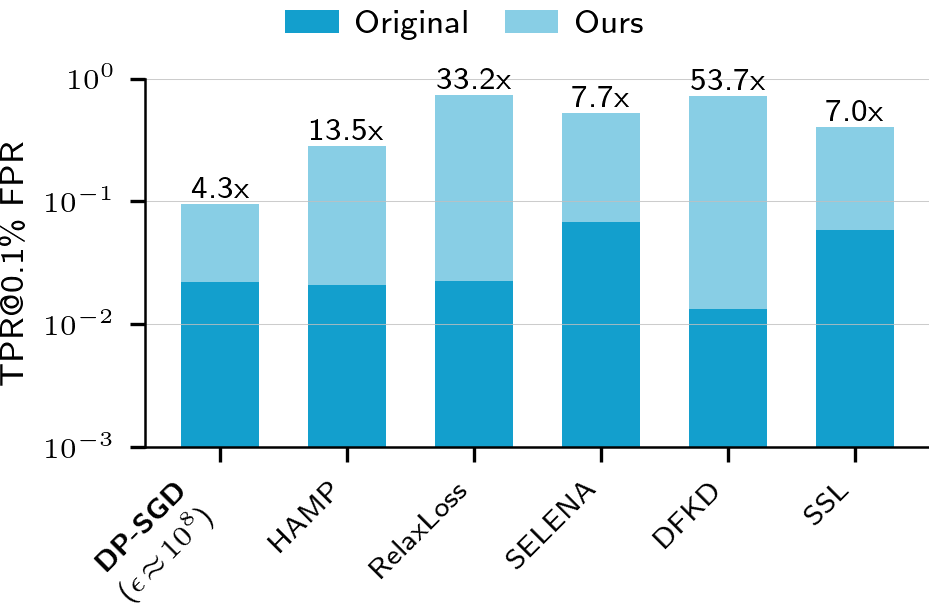

In [9]:
fig, ax = plt.subplots()

DEFENSE_LABELS = {
    "dpsgd": "\\textbf{DP-SGD}\n($\\epsilon\\!\\approx\\!10^8$)",
    "hamp": "HAMP",
    "relax_loss": "RelaxLoss",
    "selena": "SELENA",
    "dfkd": "DFKD",
    "ssl_simclr": r"SSL",
}

LEGEND_LABELS = {
    "original": "Original",
    "ours": "Ours",
}

COLORS = {
    "original": "C0",
    "ours": "C0",
}

HATCH = {
    "original": None,
    "ours": None,
}

ALPHAS = {
    "original": 1.0,
    "ours": 0.5,
}

bar_keys = list(DEFENSE_LABELS.values())
x_ticks = np.arange(len(bar_keys))
z_orders = (1.5, 1.0)

prev = np.zeros(len(DEFENSE_LABELS))
for setting_idx, setting in enumerate(("original", "ours")):
    bar_values = np.array([plot_data[defense_name][setting] for defense_name in DEFENSE_LABELS.keys()])
    current_bars = ax.bar(
        x_ticks,
        bar_values - prev,
        bottom=prev,
        width=plot_util.BAR_WIDTH,
        color=COLORS[setting],
        hatch=HATCH[setting],
        alpha=ALPHAS[setting],
        zorder=z_orders[setting_idx],
        label=LEGEND_LABELS[setting],
    )
    if setting_idx > 0:
        increases = bar_values / prev
        ax.bar_label(
            current_bars,
            labels=[f"{increase:.1f}x" for increase in increases],
            label_type="edge",
            fontsize="small",
        )
    
    prev[:] = bar_values

ax.set_xticks(x_ticks)
ax.set_xticklabels(bar_keys, rotation=45, ha="right")
ax.set_yscale("log")
ax.minorticks_off()
ax.set_ylim(1e-3, 1)
ax.set_ylabel(r"TPR@0.1\% FPR")
ax.grid(which="major", axis="y")
fig.legend(loc="outside upper center", ncol=2)
plot_util.resize_figure_with_legend(fig)
fig.savefig(PLOT_BASE_DIR / "teaser.pdf")

plt.show(fig)
plt.close(fig)

## Strongest canary

In [10]:
# Always use the maximum TPR over {w/ DA, w/o DA} x {logit, hinge} for LiRA

defense_data_info = {}

## SELENA
SELENA_ORIGINAL = "lira_da", "logit"
SELENA_BOTH = "lira_da", "logit"
defense_data_info["selena"] = {
    "original": {
        "attack_dir": SELENA_BASE_DIR / "clean",
        "suffix": f"student_{SELENA_ORIGINAL[0]}_{SELENA_ORIGINAL[1]}",
    },
    "clean": {
        "attack_dir": SELENA_BASE_DIR / "clean",
        "suffix": f"student_{SELENA_BOTH[0]}_{SELENA_BOTH[1]}",
    },
    "worst_case": {
        "attack_dir": SELENA_BASE_DIR / "duplicates_mislabel_half",
        "suffix": f"student_{SELENA_BOTH[0]}_{SELENA_BOTH[1]}",
    }
}

## SSL
SSL_ORIGINAL = "lira_da", "confidence"
SSL_BOTH = "lira_da", "backbone"
for ssl_method, base_dir in (("simclr", SSL_SIMCLR_BASE_DIR), ("moco", SSL_MOCO_BASE_DIR)):
    defense_data_info[f"ssl_{ssl_method}"] = {
        "original": {
            "attack_dir": base_dir / "clean",
            "suffix": f"{SSL_ORIGINAL[0]}_{SSL_ORIGINAL[1]}",
        },
        "clean": {
            "attack_dir": base_dir / "clean",
            "suffix": f"{SSL_BOTH[0]}_{SSL_BOTH[1]}",
        },
        "worst_case": {
            "attack_dir": base_dir / "ood",
            "suffix": f"{SSL_BOTH[0]}_{SSL_BOTH[1]}",
        }
    }

## DFKD
DFKD_ORIGINAL = "lira_da", "logit"
DFKD_BOTH = "lira_da", "logit"
defense_data_info["dfkd"] = {
    "original": {
        "attack_dir": DFKD_BASE_DIR / "clean",
        "suffix": f"{DFKD_ORIGINAL[0]}_{DFKD_ORIGINAL[1]}",
    },
    "clean": {
        "attack_dir": DFKD_BASE_DIR / "clean",
        "suffix": f"{DFKD_BOTH[0]}_{DFKD_BOTH[1]}",
    },
    "worst_case": {
        "attack_dir": DFKD_BASE_DIR / "label_noise",
        "suffix": f"{DFKD_BOTH[0]}_{DFKD_BOTH[1]}",
    }
}

## HAMP
HAMP_ORIGINAL = "lira_da", "logit"
HAMP_BOTH = "labelonly", "default"
HAMP_HP_IDX = 4
defense_data_info["hamp"] = {
    "original": {
        "attack_dir": HAMP_BASE_DIR / "clean" / f"attack_train_{HAMP_HP_IDX}",
        "suffix": f"testtime_{HAMP_ORIGINAL[0]}_{HAMP_ORIGINAL[1]}",
    },
    "clean": {
        "attack_dir": HAMP_BASE_DIR / "clean" / f"attack_train_{HAMP_HP_IDX}",
        "suffix": f"{HAMP_BOTH[0]}_{HAMP_BOTH[1]}",
    },
    "worst_case": {
        "attack_dir": HAMP_BASE_DIR / "label_noise" / f"attack_train_{HAMP_HP_IDX}",
        "suffix": f"{HAMP_BOTH[0]}_{HAMP_BOTH[1]}",
    }
}

## RelaxLoss
RELAX_LOSS_CLEAN = "lira", "logit"
RELAX_LOSS_LABEL_NOISE = "lira", "hinge"
RELAX_LOSS_HP_IDX = 0
defense_data_info["relax_loss"] = {
    "original": {
        "attack_dir": RELAX_LOSS_BASE_DIR / f"clean_0" / f"attack_target_loss_{RELAX_LOSS_HP_IDX}",
        "suffix": f"{RELAX_LOSS_CLEAN[0]}_{RELAX_LOSS_CLEAN[1]}",
    },
    "clean": {
        "attack_dir": RELAX_LOSS_BASE_DIR / f"clean_0" / f"attack_target_loss_{RELAX_LOSS_HP_IDX}",
        "suffix": f"{RELAX_LOSS_CLEAN[0]}_{RELAX_LOSS_CLEAN[1]}",
    },
    "worst_case": {
        "attack_dir": RELAX_LOSS_BASE_DIR / f"label_noise_0" / f"attack_target_loss_{RELAX_LOSS_HP_IDX}",
        "suffix": f"{RELAX_LOSS_LABEL_NOISE[0]}_{RELAX_LOSS_LABEL_NOISE[1]}",
    }
}

## Undefended
UNDEFENDED_ORIGINAL = "lira_da", "hinge"
UNDEFENDED_BOTH = "lira_da", "hinge"
defense_data_info["undefended"] = {
    "original": {
        "attack_dir": UNDEFENDED_BASE_DIR / "clean",
        "suffix": f"{UNDEFENDED_ORIGINAL[0]}_{UNDEFENDED_ORIGINAL[1]}",
    },
    "clean": {
        "attack_dir": UNDEFENDED_BASE_DIR / "clean",
        "suffix": f"{UNDEFENDED_BOTH[0]}_{UNDEFENDED_BOTH[1]}",
    },
    "worst_case": {
        "attack_dir": UNDEFENDED_BASE_DIR / "label_noise",
        "suffix": f"{UNDEFENDED_BOTH[0]}_{UNDEFENDED_BOTH[1]}",
    },
}


In [11]:
plot_data = {}
for defense_name, defense_info in defense_data_info.items():
    plot_data[defense_name] = {}
    for experiment_name, experiment_info in defense_info.items():
        attack_membership = torch.load(
            experiment_info["attack_dir"] / f"attack_membership_{experiment_info['suffix']}.pt"
        ).numpy()
        attack_scores = torch.load(
            experiment_info["attack_dir"] / f"attack_scores_{experiment_info['suffix']}.pt"
        ).numpy()
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            y_true=attack_membership, y_score=attack_scores,
        )
        plot_data[defense_name][experiment_name] = max(tpr[fpr <= TARGET_FPR])


hamp: Relative increase 8.5, max 28.5%
relax_loss: Relative increase 33.2, max 74.1%
selena: Relative increase 7.7, max 52.7%
dfkd: Relative increase 53.7, max 72.2%
ssl_simclr: Relative increase 2.2, max 40.6%
ssl_moco: Relative increase 2.8, max 65.0%


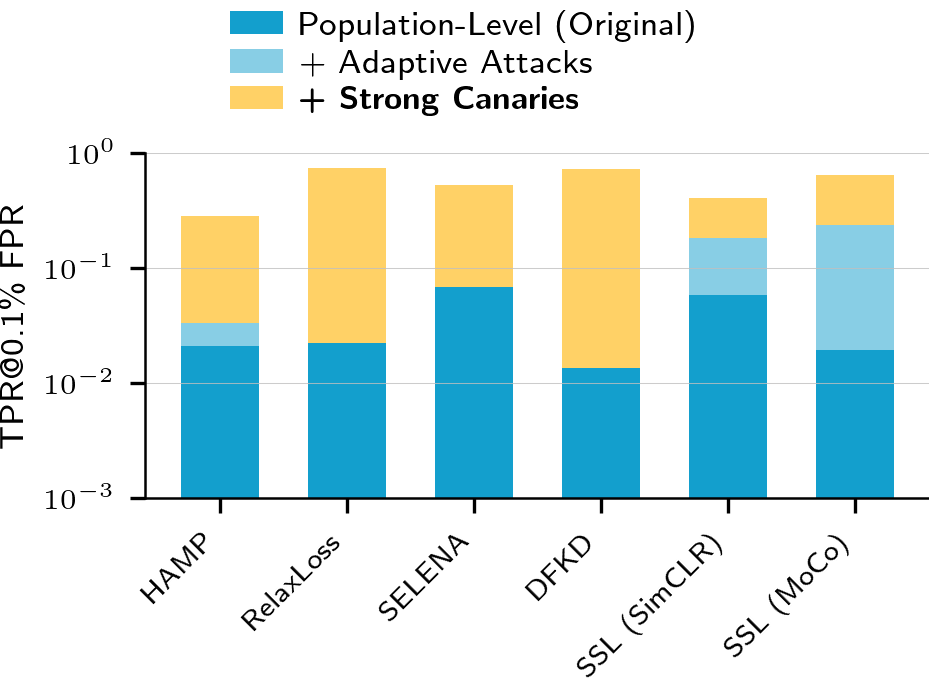

In [12]:
fig, ax = plt.subplots()

DEFENSE_LABELS = {
    "hamp": "HAMP",
    "relax_loss": "RelaxLoss",
    "selena": "SELENA",
    "dfkd": "DFKD",
    "ssl_simclr": r"SSL (SimCLR)",
    "ssl_moco": r"SSL (MoCo)",
}

COLORS = {
    "original": "C0",
    "clean": "C0",
    "worst_case": "C1",
}

ALPHAS = {
    "original": 1.0,
    "clean": 0.5,
    "worst_case": 1.0,
}

LEGEND_LABELS = {
    "original": "Population-Level (Original)",
    "clean": "+ Adaptive Attacks",
    "worst_case": r"\textbf{+ Strong Canaries}",
}

bar_keys = list(DEFENSE_LABELS.values())
x_ticks = np.arange(len(bar_keys))

bottom = np.zeros(len(DEFENSE_LABELS))
for idx, experiment_name in enumerate(("original", "clean", "worst_case")):
    bar_values = np.array([plot_data[defense_name][experiment_name] for defense_name in DEFENSE_LABELS.keys()])
    ax.bar(
        x_ticks,
        bar_values - bottom,
        bottom=bottom,
        width=plot_util.BAR_WIDTH,
        color=COLORS[experiment_name],
        alpha=ALPHAS[experiment_name],
        label=LEGEND_LABELS[experiment_name],
    )
    bottom = bar_values
for defense_name in DEFENSE_LABELS.keys():
    print(f"{defense_name}: Relative increase {plot_data[defense_name]['worst_case'] / plot_data[defense_name]['clean']:.1f}, max {plot_data[defense_name]['worst_case']:.1%}")

ax.set_xticks(x_ticks)
ax.set_xticklabels(bar_keys, rotation=45, ha="right")
ax.set_yscale("log")
ax.minorticks_off()
ax.set_ylabel(r"TPR@0.1\% FPR")
ax.set_ylim(1e-3, 1)

ax.grid(which="major", axis="y")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="outside upper center", ncol=1)

plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / "avg_vs_worst.pdf")

plt.show(fig)
plt.close(fig)

# General plots

## Per-sample TPRs

Averaged TPR@0.1% FPR: 3.98% (±0.00)
Max TPR@0.1% FPR: 99.89%


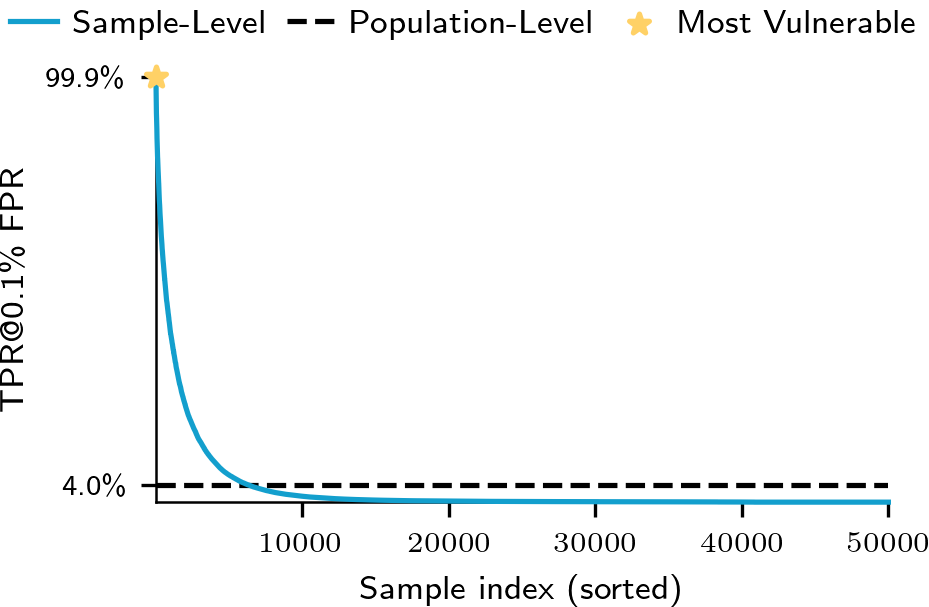

In [13]:
# Load data
per_sample_tpr_at_fpr = np.load(PER_SAMPLE_BASE_DIR / "per_sample_tpr.npy")
mean_roc_data = np.load(PER_SAMPLE_BASE_DIR / "mean_roc.npz")
all_fpr = mean_roc_data["fpr"]
all_roc_mean = mean_roc_data["tpr_mean"]
all_roc_sem = mean_roc_data["tpr_sem"]

all_tpr_at_fpr_idx = np.argmax(all_roc_mean[all_fpr <= TARGET_FPR])
all_tpr_at_fpr_mean = all_roc_mean[all_tpr_at_fpr_idx]
all_tpr_at_fpr_sem = all_roc_sem[all_tpr_at_fpr_idx]

sorted_tpr_at_fpr = np.flip(np.sort(per_sample_tpr_at_fpr))

print(f"Averaged TPR@0.1% FPR: {all_tpr_at_fpr_mean:.2%} (±{all_tpr_at_fpr_sem*100:.2f})")
print(f"Max TPR@0.1% FPR: {sorted_tpr_at_fpr[0]:.2%}")

fig, ax = plt.subplots()

xs = np.arange(1, len(sorted_tpr_at_fpr) + 1)
ax.plot(xs, sorted_tpr_at_fpr, label="Sample-Level", c="C0", clip_on=False, zorder=3)

ax.axhline(all_tpr_at_fpr_mean, c="k", ls="--", label=r"Population-Level")
ax.scatter(0, sorted_tpr_at_fpr[0], marker="*", color="C1", label="Most Vulnerable", clip_on=False, zorder=3)
ax.set_ylabel(r"TPR@0.1\% FPR")
ax.set_xlabel("Sample index (sorted)")
ax.set_xlim(xs[0], xs[-1])
ax.set_yticks((0, all_tpr_at_fpr_mean, sorted_tpr_at_fpr[0]))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))

ax.set_ylim(1/25000, 1)

fig.legend(loc="outside upper center", ncol=3, handlelength=1.4, columnspacing=0.6)
plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / "per_sample_tpr.pdf")
plt.show(fig)
plt.close(fig)


## Justification of leave-one-out setting

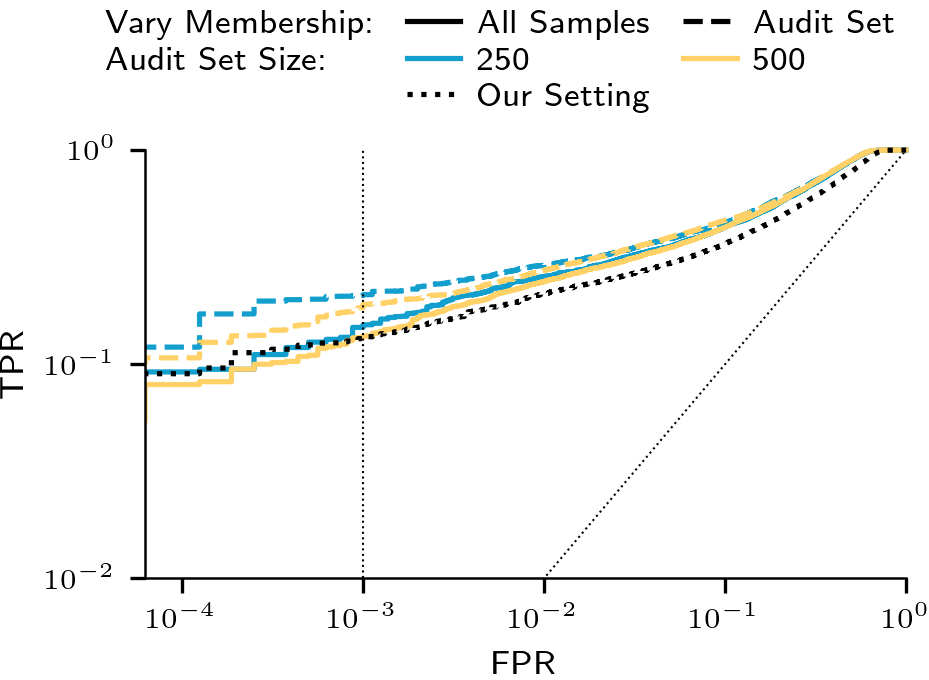

In [14]:
ATTACKS = {
    "fixed_halves_false": ("lira_da", "logit"),
    "fixed_halves_true": ("lira_da", "logit"),
    "fixed_halves_false_500": ("lira_da", "hinge"),
    "fixed_halves_true_500": ("lira_da", "logit"),
}
LEGEND_LABELS = {
    "fixed_halves_false": "Vary (audit 250)",
    "fixed_halves_true": "Fixed (audit 250)",
    "fixed_halves_false_500": "Vary (audit 500)",
    "fixed_halves_true_500": "Fixed (audit 500)",
    "undefended_ours": "Ours",
}

COLORS = {
    "fixed_halves_false": "C0",
    "fixed_halves_true": "C0",
    "fixed_halves_false_500": "C1",
    "fixed_halves_true_500": "C1",
    "undefended_ours": "k",
}

LINE_STYLES = {
    "fixed_halves_false": "solid",
    "fixed_halves_true": "dashed",
    "fixed_halves_false_500": "solid",
    "fixed_halves_true_500": "dashed",
    "undefended_ours": "dotted",
}

fig, ax = plt.subplots()

ax.plot((0, 1), (0, 1), ls="dotted", c="k", lw=0.5)

for experiment_idx, (experiment_name, (attack, score)) in enumerate(ATTACKS.items()):
    attack_dir = VALIDATE_LOO_BASE_DIR / experiment_name
    attack_membership = torch.load(
        attack_dir / f"attack_membership_{attack}_{score}.pt"
    ).numpy()
    attack_scores = torch.load(
        attack_dir / f"attack_scores_{attack}_{score}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_true=attack_membership, y_score=attack_scores,
    )
    ax.plot(
        fpr, tpr,
        c=COLORS[experiment_name],
        ls=LINE_STYLES[experiment_name],
        label=LEGEND_LABELS[experiment_name],
    )
    
attack_dir_undefended = UNDEFENDED_BASE_DIR / "clean"
attack_membership = torch.load(
    attack_dir_undefended / f"attack_membership_lira_da_hinge.pt"
).numpy()
attack_scores = torch.load(
    attack_dir_undefended / f"attack_scores_lira_da_hinge.pt"
).numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(
    y_true=attack_membership, y_score=attack_scores,
)
ax.plot(
    fpr, tpr,
    c=COLORS["undefended_ours"],
    ls=LINE_STYLES["undefended_ours"],
    label=LEGEND_LABELS["undefended_ours"],
)

ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
ax.set_xlim(1/16000, 1)
ax.set_ylim(1e-2, 1)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.loglog()
ax.minorticks_off()
plot_util.extend_line_y_clipping(ax)

handles_labels = (
    (plot_util.proxy_patch(), "Vary Membership:"),
    (plot_util.proxy_patch(), "Audit Set Size:"),
    (plot_util.proxy_patch(), ""),
    (matplotlib.lines.Line2D([0], [0], color="k", linestyle=LINE_STYLES["fixed_halves_false"]), "All Samples"),
    (matplotlib.lines.Line2D([0], [0], color=COLORS["fixed_halves_false"], linestyle="solid"), "250"),
    (matplotlib.lines.Line2D([0], [0], color=COLORS["undefended_ours"], linestyle=LINE_STYLES["undefended_ours"]), "Our Setting"),
    (matplotlib.lines.Line2D([0], [0], color="k", linestyle=LINE_STYLES["fixed_halves_true"]), "Audit Set"),
    (matplotlib.lines.Line2D([0], [0], color=COLORS["fixed_halves_false_500"], linestyle="solid"), "500"),
    (plot_util.proxy_patch(), ""),
)
handles, labels = zip(*handles_labels)

fig.legend(handles, labels, loc="outside upper center", ncol=3)
plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / "validate_loo.pdf")
plt.show(fig)
plt.close(fig)


## Compare ROC on most vulnerable vs. canaries as a proxy

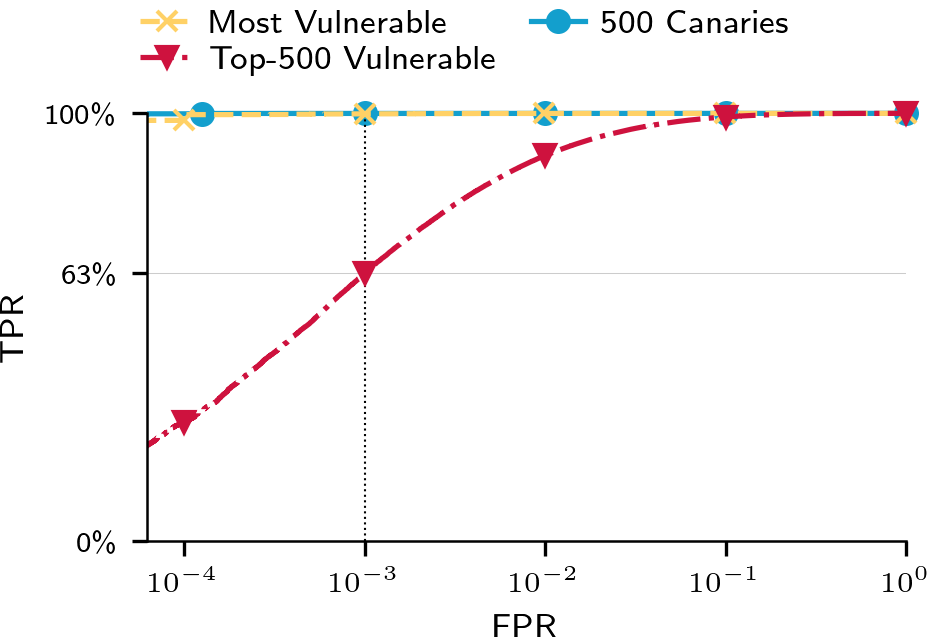

In [15]:
SETTINGS = (
    "max",
    "topk",
    "ours",
)
VALIDATE_LOO_EXPERIMENTS = {
    "ours": "fixed_halves_false_500_label_noise",
}
VALIDATE_LOO_ATTACK = "lira_da"
VALIDATE_LOO_SCORE = "logit"

rocs = {}
for setting, experiment_name in VALIDATE_LOO_EXPERIMENTS.items():
    attack_dir = VALIDATE_LOO_BASE_DIR / experiment_name
    attack_membership = torch.load(
        attack_dir / f"attack_membership_{VALIDATE_LOO_ATTACK}_{VALIDATE_LOO_SCORE}.pt"
    ).numpy()
    attack_scores = torch.load(
        attack_dir / f"attack_scores_{VALIDATE_LOO_ATTACK}_{VALIDATE_LOO_SCORE}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
    )
    rocs[setting] = fpr, tpr

max_data = np.load(PER_SAMPLE_BASE_DIR / "most_vulnerable_roc.npz")
rocs["max"] = max_data["fpr"], max_data["tpr"]
topk_data = np.load(PER_SAMPLE_BASE_DIR / "topk_vulnerable_roc.npz")
rocs["topk"] = topk_data["fpr"], topk_data["tpr"]

LEGEND_LABELS = {
    "max": "Most Vulnerable",
    "topk": "Top-500 Vulnerable",
    "ours": r"500 Canaries",
}

COLORS = {
    "ours": "C0",
    "topk": "C2",
    "max": "C1",
}

MARKERS = {
    "ours": "o",
    "topk": "v",
    "max": "x",
}
ZORDERS = {
    "ours": 2,
    "topk": 2.5,
    "max": 2.5,
}

LINE_STYLES = {
    "ours": "solid",
    "max": "dashed",
    "topk": "dashdot",
}

fig, ax = plt.subplots()

tpr_at_fpr_values = {}
for setting in SETTINGS:
    fpr, tpr = rocs[setting]
    # Manually determine marker indices to have close markers
    marker_positions = np.argmin(np.abs(np.reshape(fpr, (-1, 1)) - np.logspace(-4, 0, 5)), axis=0)
    ax.plot(
        fpr, tpr,
        c=COLORS[setting],
        ls=LINE_STYLES[setting],
        label=LEGEND_LABELS[setting],
        marker=MARKERS[setting],
        markevery=marker_positions,
        zorder=ZORDERS[setting],
    )
    tpr_at_fpr_values[setting] = max(tpr[fpr <= TARGET_FPR])

ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
ax.set_yticks((0.0, tpr_at_fpr_values["topk"], 1.0))
ax.set_yticks((), minor=True)
ax.set_xlim(1/16000, 1)
ax.set_ylim(0, 1)
ax.set_xscale("log")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.grid(which="major", axis="y")
ax.minorticks_off()
plot_util.extend_line_y_clipping(ax)

fig.legend(loc="outside upper center", ncol=2)
plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / "roc_common_max_ours.pdf")
plt.show(fig)
plt.close(fig)


## Examples of most vulnerable CIFAR-10 samples

Files already downloaded and verified


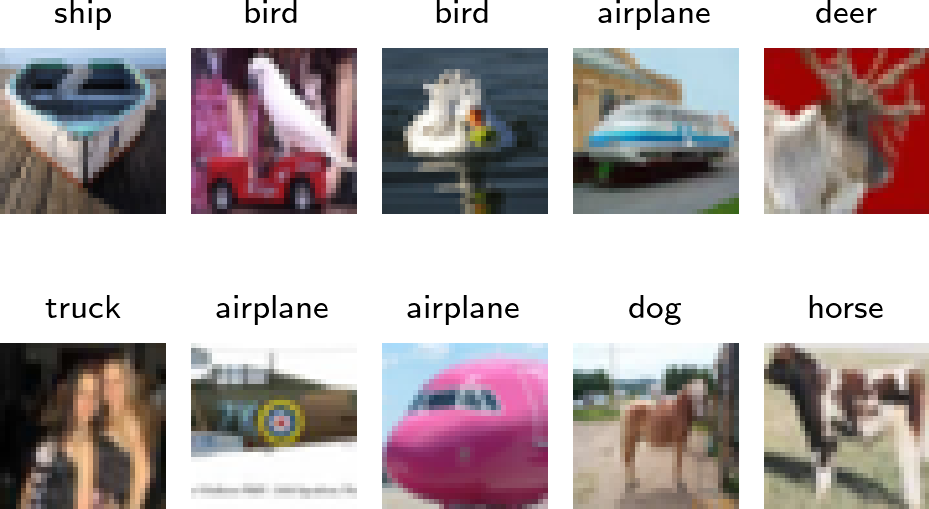

In [16]:
VIS_INDICES_RANK = (
    1,
    2,
    3,
    4,
    7,
    12,
    13,
    16,
    41,
    46,
)

# Get indices of most vulnerable samples w.r.t. 20k shadow models
per_sample_tpr_at_fpr = np.load(PER_SAMPLE_BASE_DIR / "per_sample_tpr.npy")
sorted_sample_indices = np.flip(np.argsort(per_sample_tpr_at_fpr))

dataset = torchvision.datasets.CIFAR10(root=os.environ["DATA_ROOT"], train=True, download=True)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

fig, axes = plt.subplots(2, 5)
for sample_rank_idx, ax in zip(VIS_INDICES_RANK, axes.flat):
    sample_idx = sorted_sample_indices[sample_rank_idx]
    ax.imshow(dataset.data[sample_idx])
    ax.set_title(
        f"{idx_to_class[dataset.targets[sample_idx]]}",
    )
    ax.axis("off")

fig.savefig(PLOT_BASE_DIR / "most_vulnerable_examples.pdf")
plt.show(fig)
plt.close(fig)


Files already downloaded and verified


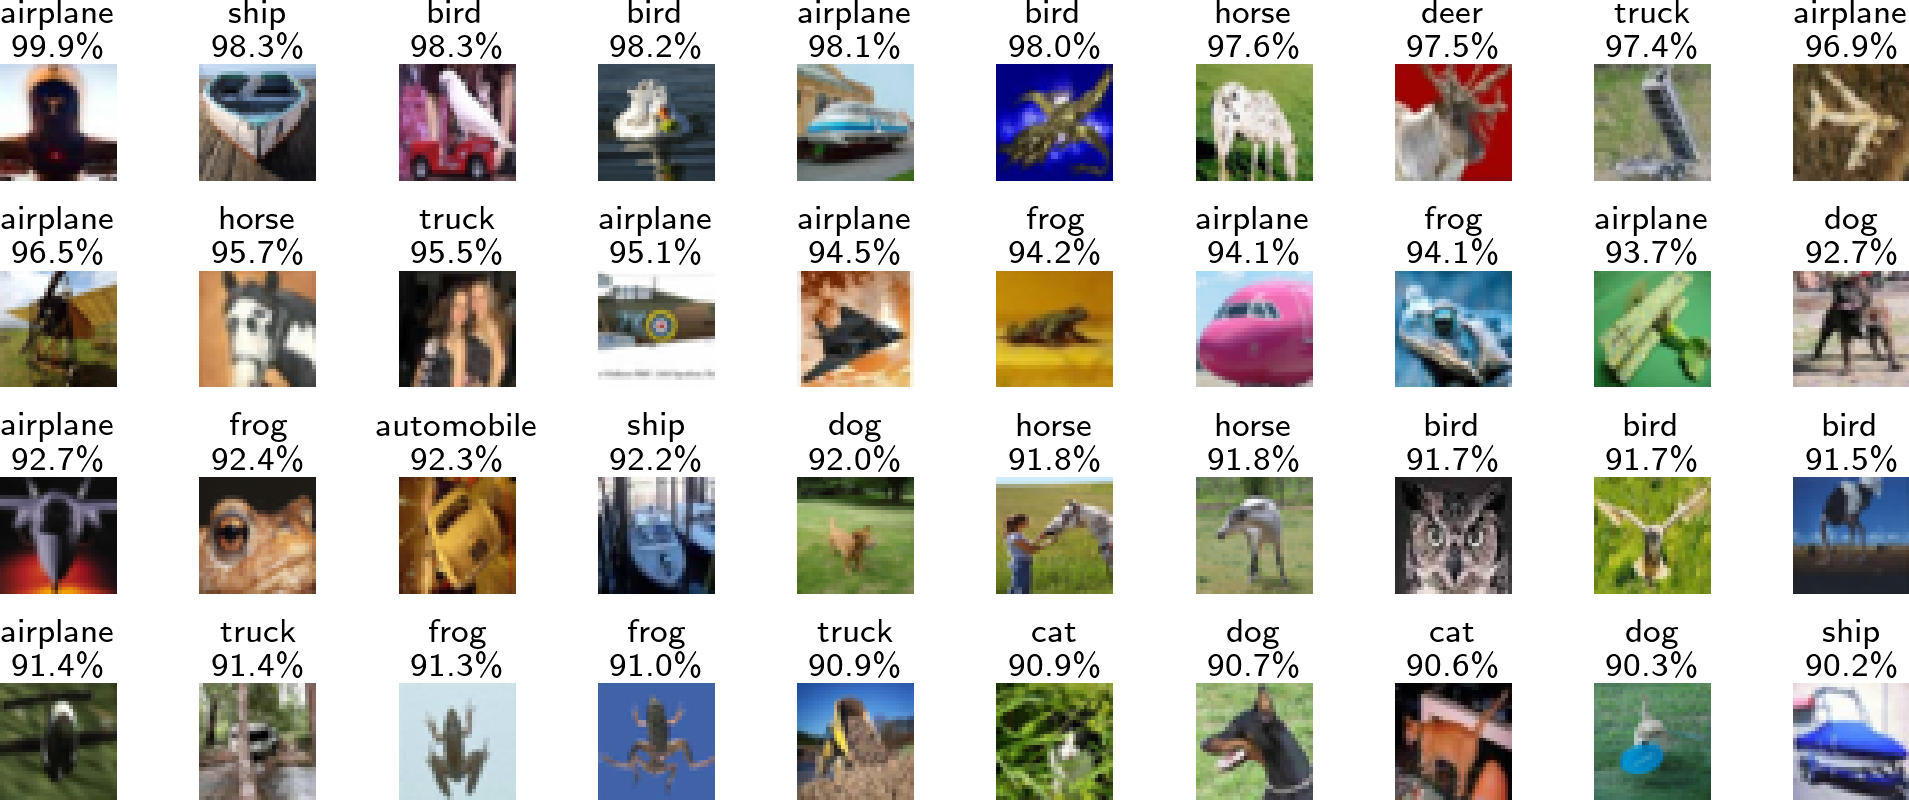

In [17]:
# Get indices of most vulnerable samples w.r.t. 20k shadow models
per_sample_tpr_at_fpr = np.load(PER_SAMPLE_BASE_DIR / "per_sample_tpr.npy")
sorted_sample_indices = np.flip(np.argsort(per_sample_tpr_at_fpr))

dataset = torchvision.datasets.CIFAR10(root=os.environ["DATA_ROOT"], train=True, download=True)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

fig, axes = plt.subplots(4, 10, figsize=plot_util.FIGURE_SIZE_TWOCOL_IN)
for idx, ax in enumerate(axes.flat):
    sample_idx = sorted_sample_indices[idx]
    ax.imshow(dataset.data[sample_idx])
    ax.set_title(
        f"{idx_to_class[dataset.targets[sample_idx]]}\n{per_sample_tpr_at_fpr[sample_idx] * 100:.1f}\\%",
        y=0.85,
    )
    ax.axis("off")

fig.savefig(PLOT_BASE_DIR / "most_vulnerable_examples_aux.pdf")
plt.show(fig)
plt.close(fig)


# SSL

## Adaptive attack

simclr confidence: 5.8%
simclr similarity: 7.1%
simclr backbone: 18.2%


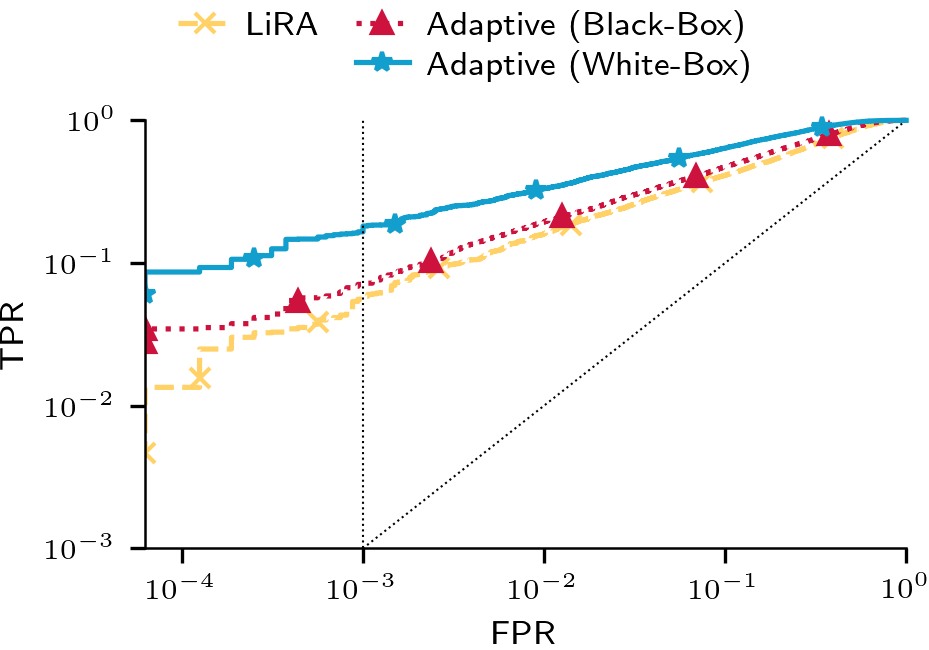

moco confidence: 2.0%
moco similarity: 3.6%
moco backbone: 23.6%


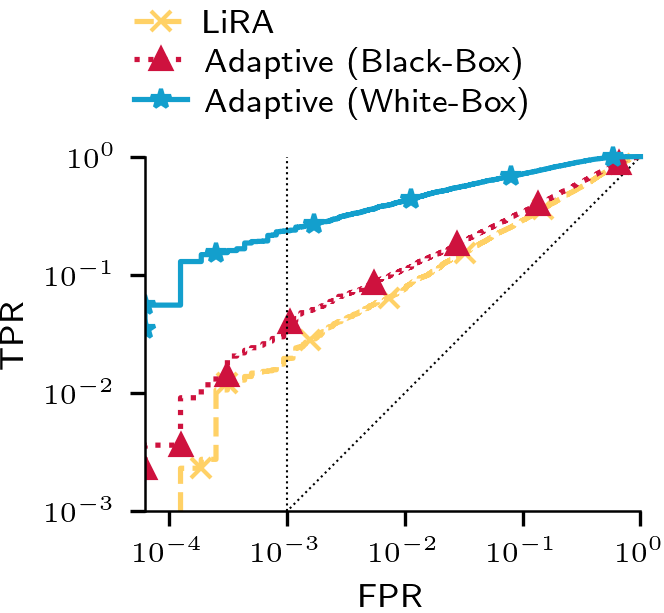

In [18]:
SCORES = ("confidence", "similarity", "backbone")
EXPERIMENT = "clean"
METHODS = ("simclr", "moco")
METHOD_BASE_DIRS = {
    "moco": SSL_MOCO_BASE_DIR,
    "simclr": SSL_SIMCLR_BASE_DIR,
}
METHOD_FIG_SIZES = {
    "moco": plot_util.FIGURE_SIZE_REDUCED_IN,
    "simclr": plot_util.FIGURE_SIZE_ONECOL_IN,
}
METHOD_LEGEND_COLS = {
    "moco": 1,
    "simclr": 2,
}

LEGEND_LABELS = {
    "confidence": "LiRA",
    "similarity": "Adaptive (Black-Box)",
    "backbone": "Adaptive (White-Box)",
}

COLORS = {
    "confidence": "C1",
    "similarity": "C2",
    "backbone": "C0",
}

LINE_STYLES = {
    "confidence": "dashed",
    "similarity": "dotted",
    "backbone": "solid",
}

MARKERS = {
    "confidence": "x",
    "similarity": "^",
    "backbone": "*",
}

for method in METHODS:
    base_dir = METHOD_BASE_DIRS[method]
    
    fig, ax = plt.subplots(figsize=METHOD_FIG_SIZES[method])
    ax.plot((0, 1), (0, 1), ls="dotted", c="k", lw=0.5)
    for score in SCORES:
        attack_membership = torch.load(
            base_dir / EXPERIMENT / f"attack_membership_lira_da_{score}.pt"
        ).numpy()
        attack_scores = torch.load(
            base_dir / EXPERIMENT / f"attack_scores_lira_da_{score}.pt"
        ).numpy()
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
        )
        ax.plot(
            fpr, tpr,
            c=COLORS[score],
            ls=LINE_STYLES[score],
            label=f"{LEGEND_LABELS[score]}",
            marker=MARKERS[score],
            markevery=0.2,
        )
        print(f"{method} {score}: {max(tpr[fpr <= TARGET_FPR]):.1%}")
    
    ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
    ax.set_xlim(1/16000, 1)
    ax.set_ylim(1e-3, 1)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.loglog()
    ax.minorticks_off()
    plot_util.extend_line_y_clipping(ax)

    handles, labels = ax.get_legend_handles_labels()
    if METHOD_LEGEND_COLS[method] == 2:
        handles.insert(1, plot_util.proxy_patch())
        labels.insert(1, "")
    fig.legend(handles, labels, loc="outside upper center", ncol=METHOD_LEGEND_COLS[method])
    plot_util.resize_figure_with_legend(fig)
    
    fig.savefig(PLOT_BASE_DIR / f"ssl_attack_{method}.pdf")
    plt.show(fig)
    plt.close(fig)


## OOD canaries

clean backbone: 18.2%
ood backbone: 40.6%


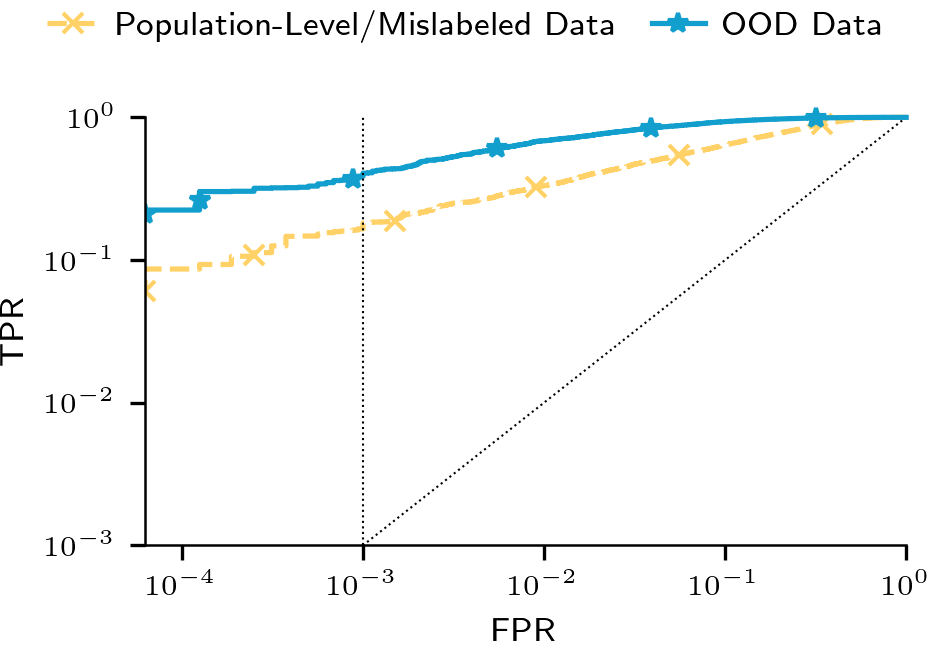

In [19]:
SCORE = "backbone"
EXPERIMENTS = (
    "clean",
    "ood",
)
METHOD_BASE_DIR = SSL_SIMCLR_BASE_DIR

LEGEND_LABELS = {
    "clean": "Population-Level/Mislabeled Data",
    "ood": "OOD Data",
}

COLORS = {
    "clean": "C1",
    "ood": "C0",
}

MARKERS = {
    "clean": "x",
    "ood": "*",
}

LINE_STYLES = {
    "clean": "dashed",
    "ood": "solid",
}
    
fig, ax = plt.subplots()
ax.plot((0, 1), (0, 1), ls="dotted", c="k", lw=0.5)
for experiment in EXPERIMENTS:
    attack_membership = torch.load(
        METHOD_BASE_DIR / experiment / f"attack_membership_lira_da_{SCORE}.pt"
    ).numpy()
    attack_scores = torch.load(
        METHOD_BASE_DIR / experiment / f"attack_scores_lira_da_{SCORE}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
    )
    ax.plot(
        fpr, tpr,
        c=COLORS[experiment],
        ls=LINE_STYLES[experiment],
        label=f"{LEGEND_LABELS[experiment]}",
        marker=MARKERS[experiment],
        markevery=0.2,
    )
    print(f"{experiment} {SCORE}: {max(tpr[fpr <= TARGET_FPR]):.1%}")

ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
ax.set_xlim(1/16000, 1)
ax.set_ylim(1e-3, 1)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.loglog()
ax.minorticks_off()
plot_util.extend_line_y_clipping(ax)

handles, labels = ax.get_legend_handles_labels()
# Add empty row for alignment
handles.insert(1, plot_util.proxy_patch())
labels.insert(1, "")
fig.legend(handles, labels, loc="outside upper center", ncol=2)
plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / f"ssl_ood.pdf")
plt.show(fig)
plt.close(fig)


## OOD canaries (full)

simclr clean similarity: 7.1%
simclr ood similarity: 13.7%
simclr label_noise similarity: 7.1%
simclr clean backbone: 18.2%
simclr ood backbone: 40.6%


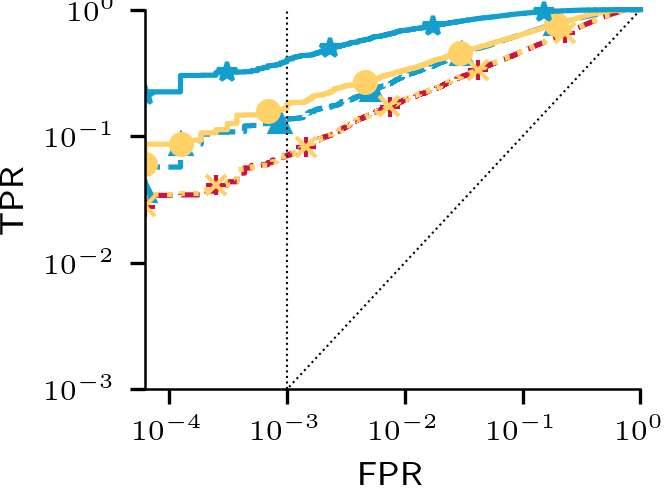

moco clean similarity: 3.6%
moco ood similarity: 6.1%
moco label_noise similarity: 3.1%
moco clean backbone: 23.6%
moco ood backbone: 65.0%


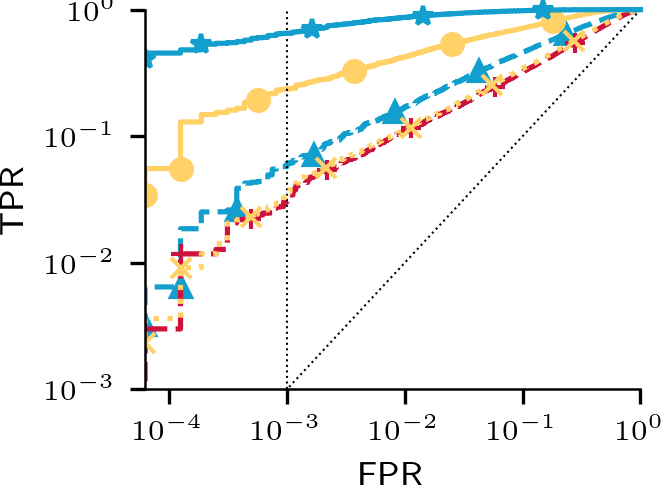

In [20]:
SCORES = ("similarity", "backbone")
EXPERIMENTS = (
    "clean",
    "ood",
    "label_noise",
)
METHODS = ("simclr", "moco")
METHOD_BASE_DIRS = {
    "moco": SSL_MOCO_BASE_DIR,
    "simclr": SSL_SIMCLR_BASE_DIR,
}

LEGEND_LABELS = {
    "clean_backbone": "Population-Level/Mislabeled (White-Box)",
    "ood_backbone": "OOD (White-Box)",
    "clean_similarity": "Population-Level (Black-Box)",
    "label_noise_similarity": "Mislabeled (Black-Box)",
    "ood_similarity": "OOD (Black-Box)",
}

COLORS = {
    "clean_backbone": "C1",
    "clean_similarity": "C1",
    "ood_backbone": "C0",
    "ood_similarity": "C0",
    "label_noise_similarity": "C2",
}

MARKERS = {
    "clean_backbone": "o",
    "ood_backbone": "*",
    "clean_similarity": "x",
    "label_noise_similarity": "+",
    "ood_similarity": "^",
}

LINE_STYLES = {
    "clean_backbone": "solid",
    "ood_backbone": "solid",
    "clean_similarity": "dotted",
    "label_noise_similarity": "dashed",
    "ood_similarity": "dashed",
}

ZORDERS = {
    "clean_backbone": 2,
    "ood_backbone": 2.1,
    "clean_similarity": 2.1,
    "label_noise_similarity": 2,
    "ood_similarity": 2,
}

handles, labels = None, None
for method in METHODS:
    base_dir = METHOD_BASE_DIRS[method]
    
    fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_REDUCED_IN)
    ax.plot((0, 1), (0, 1), ls="dotted", c="k", lw=0.5)
    for score in SCORES:
        for experiment in EXPERIMENTS:
            tag = f"{experiment}_{score}"
            if experiment == "label_noise" and score == "backbone":
                continue
            
            attack_membership = torch.load(
                base_dir / experiment / f"attack_membership_lira_da_{score}.pt"
            ).numpy()
            attack_scores = torch.load(
                base_dir / experiment / f"attack_scores_lira_da_{score}.pt"
            ).numpy()
            fpr, tpr, _ = sklearn.metrics.roc_curve(
                y_true=attack_membership, y_score=attack_scores,
            )
            ax.plot(
                fpr, tpr,
                c=COLORS[tag],
                ls=LINE_STYLES[tag],
                label=f"{LEGEND_LABELS[tag]}",
                marker=MARKERS[tag],
                zorder=ZORDERS[tag],
                markevery=0.2,
            )
            print(f"{method} {experiment} {score}: {max(tpr[fpr <= TARGET_FPR]):.1%}")
    
    ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
    ax.set_xlim(1/16000, 1)
    ax.set_ylim(1e-3, 1)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.loglog()
    ax.minorticks_off()
    plot_util.extend_line_y_clipping(ax)
    
    handles, labels = ax.get_legend_handles_labels()    
    # fig.legend(handles, labels, loc="outside upper center", ncol=2)
    # plot_util.resize_figure_with_legend(fig)
    
    fig.savefig(PLOT_BASE_DIR / f"ssl_ood_{method}.pdf")
    plt.show(fig)
    plt.close(fig)
    
assert handles is not None and labels is not None
legend_fig = plt.figure(figsize=(2 * plot_util.FIGURE_SIZE_REDUCED_IN[0], 0.4))
legend_fig.legend(handles, labels, loc="upper center", ncol=2)
legend_fig.savefig(PLOT_BASE_DIR / "ssl_ood_legend.pdf")
plt.close(legend_fig)

## Mislabeled training accuracy

In [21]:
for ssl_method, base_dir in (("simclr", SSL_SIMCLR_BASE_DIR), ("moco", SSL_MOCO_BASE_DIR)):
    client = mlflow.client.MlflowClient(f"file://{base_dir}/mlruns")
    experiment = client.get_experiment_by_name("label_noise")

    accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
    all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
    for shadow_model_idx in range(NUM_SHADOW):
        run, *_ = tuple(sorted(
            filter(
                lambda run: 
                    run.info.status == "FINISHED"
                    and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
                all_runs
            ),
            key=lambda run: run.info.end_time,
            reverse=True,
        ))
        assert run.info.status == "FINISHED"
        accuracies[shadow_model_idx] = run.data.metrics["train_accuracy_canaries_in"]
    mean_accuracy = np.mean(accuracies)
    sem_accuracy = np.std(accuracies) / np.sqrt(len(accuracies))
    print(f"{ssl_method} train accuracy on mislabeled canaries: {mean_accuracy:.2%} ± {sem_accuracy:.2%}")


simclr train accuracy on mislabeled canaries: 1.31% ± 0.07%
moco train accuracy on mislabeled canaries: 1.25% ± 0.07%


# HAMP

## Main result

testtime: TPR@0.1% FPR: 2.1%
Label-only: TPR@0.1% FPR: 3.3%


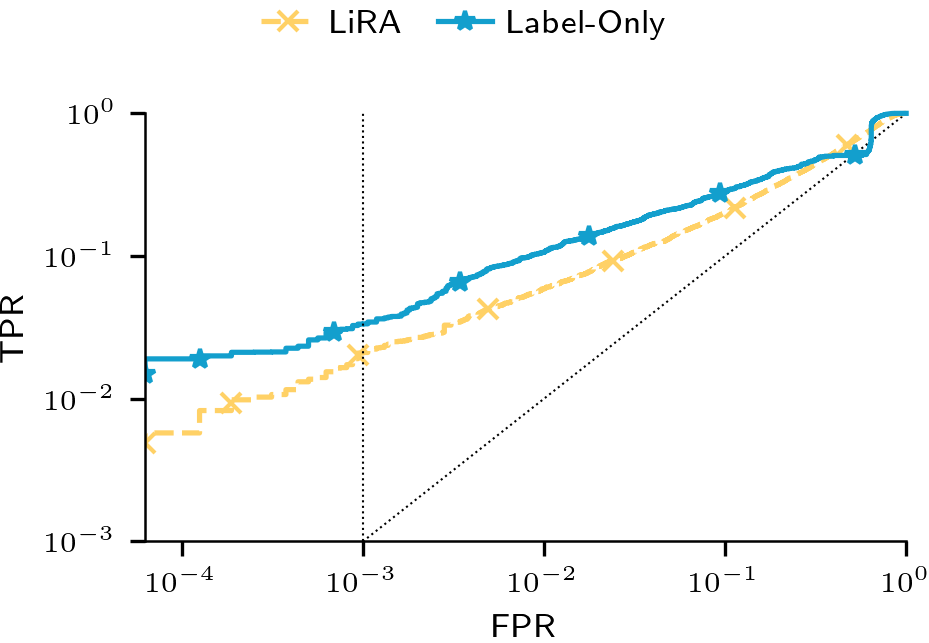

In [22]:
HP_IDX = 4
ATTACK = "lira_da"
SCORE = "logit"
EXPERIMENT = "clean"
LEGEND_LABELS = {
    "testtime": r"LiRA",
    "labelonly": "Label-Only",
}

COLORS = {
    "testtime": "C1",
    "labelonly": "C0",
}

MARKERS = {
    "testtime": "x",
    "labelonly": "*",
}

LINE_STYLES = {
    "testtime": "dashed",
    "labelonly": "solid",
}


fig, ax = plt.subplots()

ax.plot((0, 1), (0, 1), ls="dotted", c="k", lw=0.5)

attack_dir = HAMP_BASE_DIR / EXPERIMENT / f"attack_train_{HP_IDX}"

roc_curves = dict()
for defense_idx, defense in enumerate(("testtime",)):
    attack_membership = torch.load(
        attack_dir / f"attack_membership_{defense}_{ATTACK}_{SCORE}.pt"
    ).numpy()
    attack_scores = torch.load(
        attack_dir / f"attack_scores_{defense}_{ATTACK}_{SCORE}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
    )
    ax.plot(
        fpr, tpr,
        c=COLORS[defense],
        ls=LINE_STYLES[defense],
        label=LEGEND_LABELS[defense],
        marker=MARKERS[defense],
        markevery=0.2,
    )
    roc_curves[defense] = (fpr, tpr)
    print(f"{defense}: TPR@0.1% FPR: {max(tpr[fpr <= TARGET_FPR]):.1%}")

# Label-only attacks
attack_membership = torch.load(
    attack_dir / f"attack_membership_labelonly_default.pt"
).numpy()
attack_scores = torch.load(
    attack_dir / f"attack_scores_labelonly_default.pt"
).numpy()
fpr_lo, tpr_lo, _ = sklearn.metrics.roc_curve(
    y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
)
ax.plot(
    fpr_lo, tpr_lo,
    c=COLORS["labelonly"],
    ls=LINE_STYLES["labelonly"],
    label=LEGEND_LABELS["labelonly"],
    marker=MARKERS["labelonly"],
    markevery=0.2,
)
print(f"Label-only: TPR@0.1% FPR: {max(tpr_lo[fpr_lo <= TARGET_FPR]):.1%}")

ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
ax.set_xlim(1/16000, 1)
ax.set_ylim(1e-3, 1)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.loglog()
ax.minorticks_off()
plot_util.extend_line_y_clipping(ax)

handles, labels = ax.get_legend_handles_labels()
# Add empty row to align figures
handles = [handles[0], plot_util.proxy_patch(), handles[1]]
labels = [labels[0], "", labels[1]]
fig.legend(handles, labels, loc="outside upper center", ncol=2)
plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / "hamp_labelonly.pdf")
plt.show(fig)
plt.close(fig)


## Full results

traintime: TPR@0.1% FPR: 58.7%
testtime: TPR@0.1% FPR: 18.2%
Label-only (default): TPR@0.1% FPR: 28.5%
Label-only (tuned): TPR@0.1% FPR: 29.2%


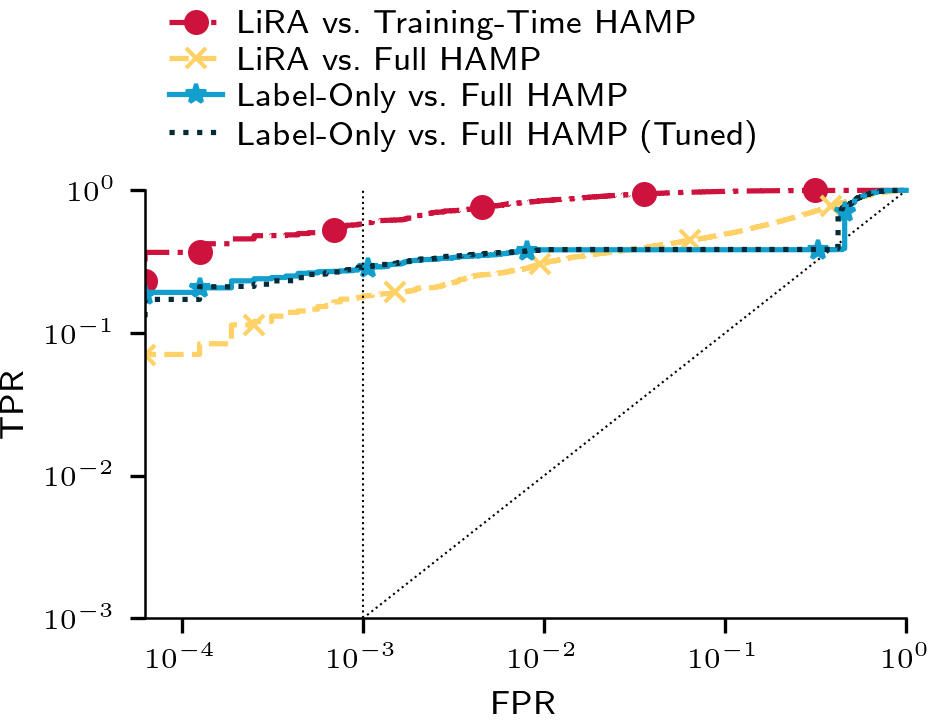

traintime: TPR@0.1% FPR: 9.4%
testtime: TPR@0.1% FPR: 2.1%
Label-only (default): TPR@0.1% FPR: 3.3%
Label-only (tuned): TPR@0.1% FPR: 3.3%


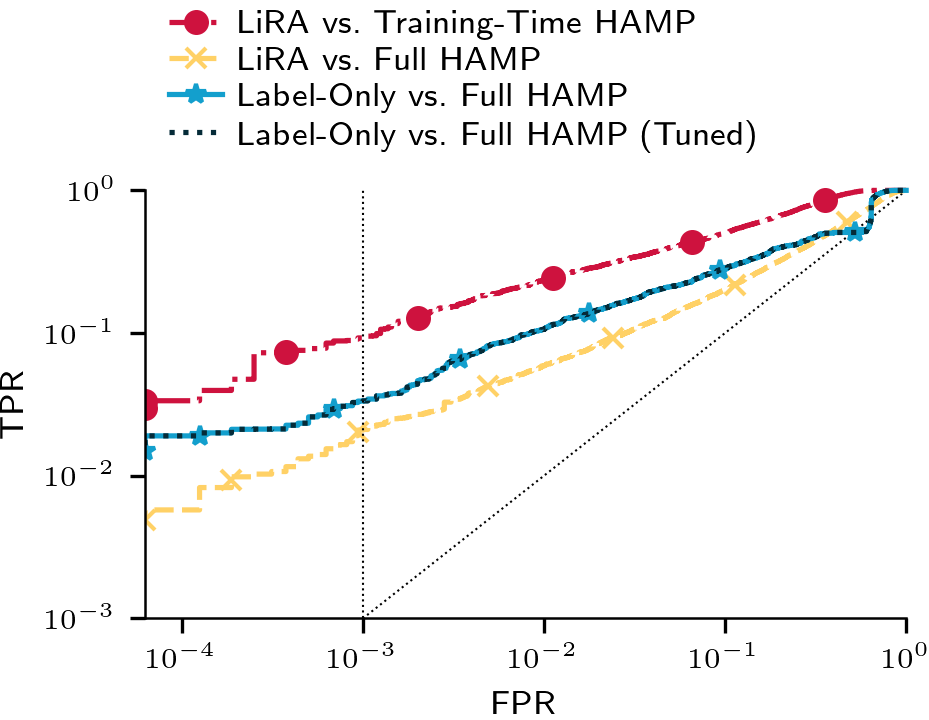

In [23]:
DEFENSES = ("traintime", "testtime")
CANARY_TYPES = ("label_noise","clean", )
HP_IDX = 4
ATTACK_SCORE = {
    "traintime": ("lira", "hinge"),
    "testtime": ("lira_da", "logit"),
}

LEGEND_LABELS = {
    "traintime": r"LiRA vs.\ Training-Time HAMP",
    "testtime": r"LiRA vs.\ Full HAMP",
    "labelonly_default": "Label-Only vs.\ Full HAMP",
    "labelonly_tuned": "Label-Only vs.\ Full HAMP (Tuned)",
}
COLORS = {
    "traintime": "C2",
    "testtime": "C1",
    "labelonly_default": "C0",
    "labelonly_tuned": "C3",
}
LINE_STYLES = {
    "traintime": "dashdot",
    "testtime": "dashed",
    "labelonly_default": "solid",
    "labelonly_tuned": "dotted",
}

MARKERS = {
    "testtime": "x",
    "labelonly_default": "*",
    "traintime": "o",
    "labelonly_tuned": None,
}


for experiment in CANARY_TYPES:
    fig, ax = plt.subplots()
    
    ax.plot((0, 1), (0, 1), ls="dotted", c="k", lw=0.5)
    
    attack_dir = HAMP_BASE_DIR / experiment / f"attack_train_{HP_IDX}"
    
    roc_curves = dict()
    for defense_idx, defense in enumerate(DEFENSES):
        attack, score = ATTACK_SCORE[defense]
        attack_membership = torch.load(
            attack_dir / f"attack_membership_{defense}_{attack}_{score}.pt"
        ).numpy()
        attack_scores = torch.load(
            attack_dir / f"attack_scores_{defense}_{attack}_{score}.pt"
        ).numpy()
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
        )
        ax.plot(
            fpr, tpr,
            c=COLORS[defense],
            ls=LINE_STYLES[defense],
            label=LEGEND_LABELS[defense],
            marker=MARKERS[defense],
            markevery=0.2,
        )
        roc_curves[defense] = (fpr, tpr)
        print(f"{defense}: TPR@0.1% FPR: {max(tpr[fpr <= TARGET_FPR]):.1%}")
    
    # Label-only attacks
    for hp_tuning in ("default", "tuned"):
        setting_key = f"labelonly_{hp_tuning}"
        attack_membership = torch.load(
            attack_dir / f"attack_membership_{setting_key}.pt"
        ).numpy()
        attack_scores = torch.load(
            attack_dir / f"attack_scores_{setting_key}.pt"
        ).numpy()
        fpr_lo, tpr_lo, _ = sklearn.metrics.roc_curve(
            y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
        )
        ax.plot(
            fpr_lo, tpr_lo,
            c=COLORS[setting_key],
            ls=LINE_STYLES[setting_key],
            label=LEGEND_LABELS[setting_key],
            marker=MARKERS[setting_key],
            markevery=0.2,
        )
        print(f"Label-only ({hp_tuning}): TPR@0.1% FPR: {max(tpr_lo[fpr_lo <= TARGET_FPR]):.1%}")
    
    ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
    ax.set_xlim(1/16000, 1)
    ax.set_ylim(1e-3, 1)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.loglog()
    ax.minorticks_off()
    plot_util.extend_line_y_clipping(ax)
    
    handles, labels = ax.get_legend_handles_labels()
    
    fig.legend(handles, labels, loc="outside upper center", ncol=1)
    plot_util.resize_figure_with_legend(fig)
    
    fig.savefig(PLOT_BASE_DIR / f"hamp_full_{experiment}.pdf")
    plt.show(fig)
    plt.close(fig)

# SELENA

## Student ROC

clean: TPR@0.1% FPR: 6.8% (1.5% at 0%)
label_noise: TPR@0.1% FPR: 13.8% (5.9% at 0%)
duplicates_mislabel_half: TPR@0.1% FPR: 52.7% (49.3% at 0%)


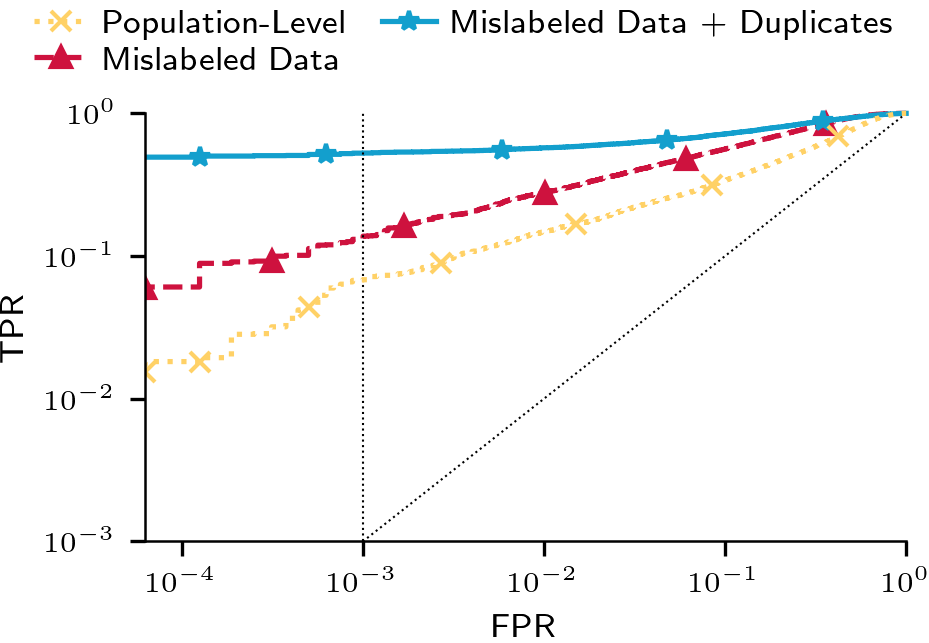

In [24]:
ATTACK = "lira_da"
SCORE = "logit"
EXPERIMENTS = ("clean", "label_noise", "duplicates_mislabel_half")
LEGEND_LABELS = {
    "clean": r"Population-Level",
    "label_noise": r"Mislabeled Data",
    "duplicates_mislabel_half": r"Mislabeled Data + Duplicates",
}

COLORS = {
    "clean": "C1",
    "label_noise": "C2",
    "duplicates_mislabel_half": "C0",
}

MARKERS = {
    "clean": "x",
    "label_noise": "^",
    "duplicates_mislabel_half": "*",
}

ZORDER = {
    "clean": 2.5,
    "label_noise": 2,
    "duplicates_mislabel_half": 2,
}

LINE_STYLES = {
    "clean": "dotted",
    "label_noise": "dashed",
    "duplicates_mislabel_half": "solid",
}

fig, ax = plt.subplots()

ax.plot((0, 1), (0, 1), ls="dotted", c="k", lw=0.5)

for experiment_idx, experiment_name in enumerate(EXPERIMENTS):
    attack_dir = SELENA_BASE_DIR / experiment_name
    attack_membership = torch.load(
        attack_dir / f"attack_membership_student_{ATTACK}_{SCORE}.pt"
    ).numpy()
    attack_scores = torch.load(
        attack_dir / f"attack_scores_student_{ATTACK}_{SCORE}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
    )
    ax.plot(
        fpr, tpr,
        c=COLORS[experiment_name],
        ls=LINE_STYLES[experiment_name],
        label=LEGEND_LABELS[experiment_name],
        marker=MARKERS[experiment_name],
        markevery=0.2,
        zorder=ZORDER[experiment_name],
    )
    print(f"{experiment_name}: TPR@0.1% FPR: {max(tpr[fpr <= TARGET_FPR]):.1%} ({max(tpr[fpr <= 0]):.1%} at 0%)")

ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
ax.set_xlim(1/16000, 1)
ax.set_ylim(1e-3, 1)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.loglog()
ax.minorticks_off()
plot_util.extend_line_y_clipping(ax)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="outside upper center", ncol=2)
plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / "selena_student.pdf")
plt.show(fig)
plt.close(fig)


## Student ROC (full)

clean: TPR@0.1% FPR: 6.8%, (1.5% at 0%)
label_noise: TPR@0.1% FPR: 13.8%, (5.9% at 0%)
duplicates: TPR@0.1% FPR: 6.9%, (3.4% at 0%)
both: TPR@0.1% FPR: 99.7%, (99.0% at 0%)
duplicates_mislabel_half: TPR@0.1% FPR: 52.7%, (49.3% at 0%)


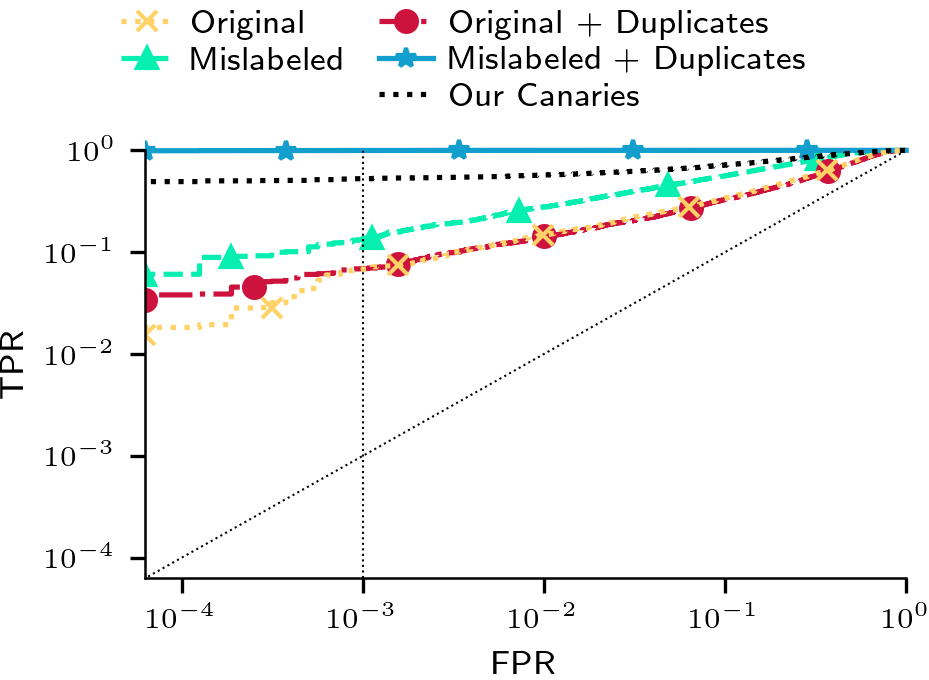

In [25]:
ATTACK = "lira_da"
SCORE = "logit"
EXPERIMENTS = ("clean", "label_noise", "duplicates", "both", "duplicates_mislabel_half")
LEGEND_LABELS = {
    "clean": r"Original",
    "label_noise": r"Mislabeled",
    "duplicates": r"Original + Duplicates",
    "both": r"Mislabeled + Duplicates",
    "duplicates_mislabel_half": "Our Canaries",
}

COLORS = {
    "clean": "C1",
    "label_noise": "C4",
    "duplicates": "C2",
    "both": "C0",
    "duplicates_mislabel_half": "k",
}

MARKERS = {
    "clean": "x",
    "label_noise": "^",
    "duplicates": "o",
    "both": "*",
    "duplicates_mislabel_half": None,
}

ZORDER = {
    "clean": 2.5,
    "label_noise": 2,
    "duplicates": 2,
    "both": 2,
    "duplicates_mislabel_half": 2,
}

LINE_STYLES = {
    "clean": "dotted",
    "label_noise": "dashed",
    "duplicates": "dashdot",
    "both": "solid",
    "duplicates_mislabel_half": "dotted",
    # "duplicates_mislabel_full": (0, (5, 1)),
}

fig, ax = plt.subplots()

ax.plot((0, 1), (0, 1), ls="dotted", c="k", lw=0.5)

for experiment_idx, experiment_name in enumerate(EXPERIMENTS):
    attack_dir = SELENA_BASE_DIR / experiment_name
    attack_membership = torch.load(
        attack_dir / f"attack_membership_student_{ATTACK}_{SCORE}.pt"
    ).numpy()
    attack_scores = torch.load(
        attack_dir / f"attack_scores_student_{ATTACK}_{SCORE}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
    )
    ax.plot(
        fpr, tpr,
        c=COLORS[experiment_name],
        ls=LINE_STYLES[experiment_name],
        label=LEGEND_LABELS[experiment_name],
        marker=MARKERS[experiment_name],
        markevery=0.2,
        zorder=ZORDER[experiment_name],
    )
    print(f"{experiment_name}: TPR@0.1% FPR: {max(tpr[fpr <= TARGET_FPR]):.1%}, ({max(tpr[fpr <= 0]):.1%} at 0%)")


ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
ax.set_xlim(1/16000, 1)
ax.set_ylim(1/16000, 1)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.loglog()
ax.minorticks_off()

plot_util.extend_line_y_clipping(ax)

handles, labels = ax.get_legend_handles_labels()
handles.insert(2, plot_util.proxy_patch())
labels.insert(2, "")
fig.legend(handles, labels, loc="outside upper center", ncol=2)

plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / "selena_student_full.pdf")
plt.show(fig)
plt.close(fig)


## Split-AI and near-duplicates

Strong canaries: TPR of 99.7% at 0.1% FPR, and 96.3% at 0 FPR


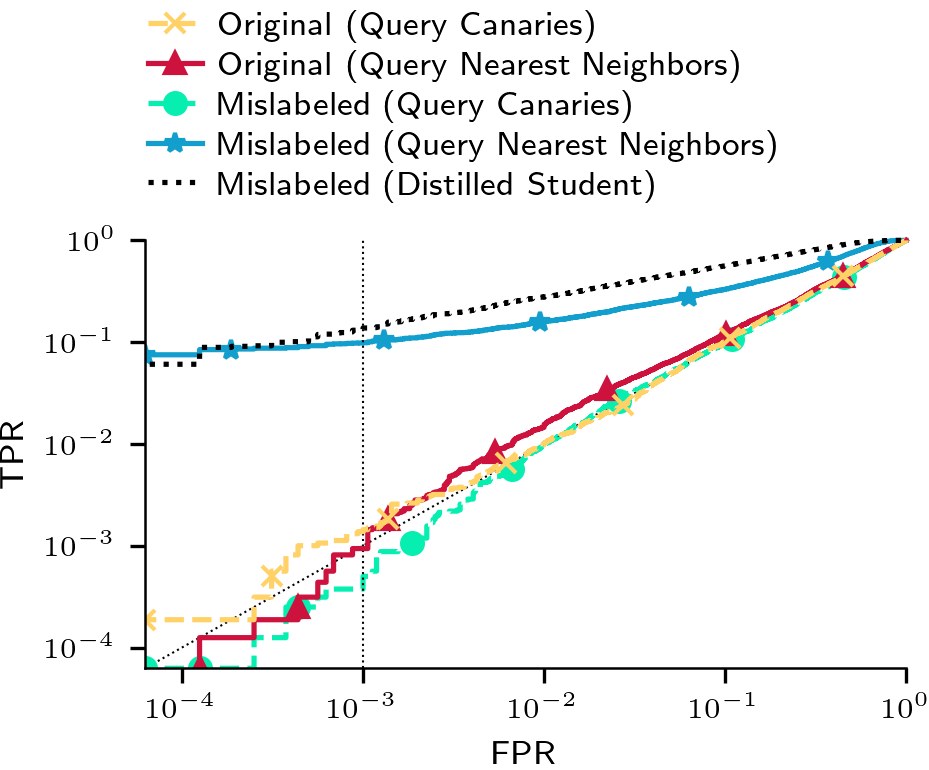

In [26]:
ATTACK = "lira"
SCORE = "logit"
STUDENT_ATTACK = "lira_da"
STUDENT_SCORE = "logit"
EXPERIMENTS = ("clean", "label_noise")
QUERY_ON = ("canaries", "nn")
LEGEND_LABELS = {
    "clean_canaries": r"Original (Query Canaries)",
    "clean_nn": r"Original (Query Nearest Neighbors)",
    "label_noise_canaries": r"Mislabeled (Query Canaries)",
    "label_noise_nn": r"Mislabeled (Query Nearest Neighbors)",
    "label_noise_student": r"Mislabeled (Distilled Student)",
}

COLORS = {
    "clean_canaries": "C1",
    "clean_nn": "C2",
    "label_noise_canaries": "C4",
    "label_noise_nn": "C0",
    "label_noise_student": "k",
}

LINE_STYLES = {
    "clean_canaries": "dashed",
    "clean_nn": "solid",
    "label_noise_canaries": "dashed",
    "label_noise_nn": "solid",
    "label_noise_student": "dotted",
}

MARKERS = {
    "clean_canaries": "x",
    "clean_nn": "^",
    "label_noise_canaries": "o",
    "label_noise_nn": "*",
    "label_noise_student": None,
}

ZORDER = {
    "clean_canaries": 2.5,
    "clean_nn": 2.4,
    "label_noise_canaries": 2,
    "label_noise_nn": 2,
    "label_noise_student": 2.5,
}

fig, ax = plt.subplots()

ax.plot((0, 1), (0, 1), ls="dotted", c="k", lw=0.5)

for experiment_idx, experiment_name in enumerate(EXPERIMENTS):
    for query_idx, query_name in enumerate(QUERY_ON):
        tag = f"{experiment_name}_{query_name}"
        attack_dir = SELENA_BASE_DIR / experiment_name
        attack_membership = torch.load(
            attack_dir / f"attack_membership_splitai_{query_name}_{ATTACK}_{SCORE}.pt"
        ).numpy()
        attack_scores = torch.load(
            attack_dir / f"attack_scores_splitai_{query_name}_{ATTACK}_{SCORE}.pt"
        ).numpy()
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
        )
        ax.plot(
            fpr, tpr,
            c=COLORS[tag],
            ls=LINE_STYLES[tag],
            label=LEGEND_LABELS[tag],
            marker=MARKERS[tag],
            markevery=0.2,
            zorder=ZORDER[tag],
        )

# Comparison to distilled student
attack_dir = SELENA_BASE_DIR / "label_noise"
attack_membership = torch.load(
    attack_dir / f"attack_membership_student_{STUDENT_ATTACK}_{STUDENT_SCORE}.pt"
).numpy()
attack_scores = torch.load(
    attack_dir / f"attack_scores_student_{STUDENT_ATTACK}_{STUDENT_SCORE}.pt"
).numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(
    y_true=attack_membership, y_score=attack_scores, drop_intermediate=False,
)
ax.plot(
    fpr, tpr,
    c=COLORS["label_noise_student"],
    ls=LINE_STYLES["label_noise_student"],
    label=LEGEND_LABELS["label_noise_student"],
    marker=MARKERS["label_noise_student"],
    markevery=0.2,
    zorder=ZORDER["label_noise_student"],
)

# Comparison to strong canaries
attack_dir = SELENA_BASE_DIR / "duplicates_mislabel_half"
attack_membership = torch.load(
    attack_dir / f"attack_membership_splitai_canaries_{ATTACK}_{SCORE}.pt"
).numpy()
attack_scores = torch.load(
    attack_dir / f"attack_scores_splitai_canaries_{ATTACK}_{SCORE}.pt"
).numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(
    y_true=attack_membership, y_score=attack_scores,
)
print(f"Strong canaries: TPR of {max(tpr[fpr <= TARGET_FPR]):.1%} at {TARGET_FPR:.1%} FPR, and {max(tpr[fpr <= 0]):.1%} at 0 FPR")

ax.axvline(1e-3, ls="dotted", c="k", lw=0.5)
ax.set_xlim(1/16000, 1)
ax.set_ylim(1/16000, 1)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.loglog()
ax.minorticks_off()
plot_util.extend_line_y_clipping(ax)

legend_handles, legend_labels = ax.get_legend_handles_labels()

fig.legend(legend_handles, legend_labels, loc="outside upper center", ncol=1)
plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / "selena_sai_nn.pdf")
plt.show(fig)
plt.close(fig)

## Examples of nearest neighbors with different labels

Files already downloaded and verified


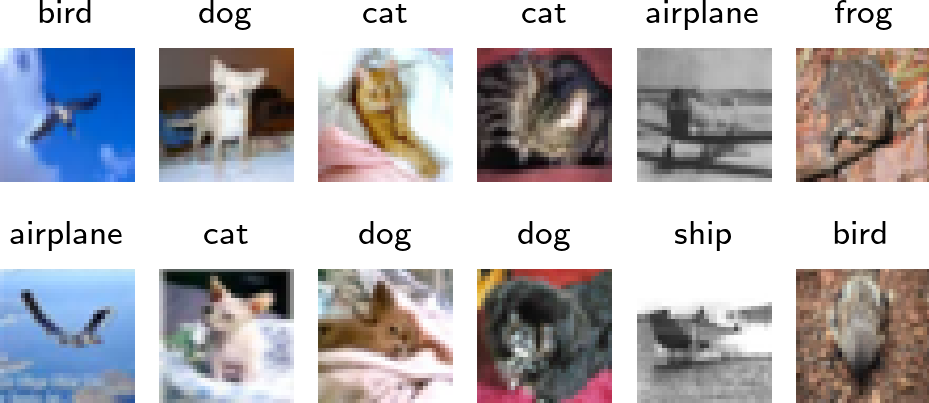

In [27]:
VIS_PAIRS = (
    (34053, 32217),
    (23285, 38126),
    (1625, 3747),
    (15169, 27679),
    (35059, 23946),
    (49351, 45533),
)

dataset = torchvision.datasets.CIFAR10(root=os.environ["DATA_ROOT"], train=True, download=True)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

fig, axes = plt.subplots(2, len(VIS_PAIRS), figsize=(plot_util.FIGURE_SIZE_ONECOL_IN[0], plot_util.FIGURE_SIZE_ONECOL_IN[1] * 0.75))
for pair_idx, (idx_a, idx_b) in enumerate(VIS_PAIRS):
    for row_idx, idx in enumerate((idx_a, idx_b)):
        ax = axes[row_idx, pair_idx]
        ax.imshow(dataset.data[idx])
        ax.set_title(
            f"{idx_to_class[dataset.targets[idx]]}",
        )
        ax.axis("off")

fig.savefig(PLOT_BASE_DIR / "different_labels_nns.pdf")
plt.show(fig)
plt.close(fig)


# DP-SGD

## Fair comparison

In [28]:
# Collect data
comparison_data = {}

## SELENA
print("# Loading SELENA data")
SELENA_BASE = "clean", "lira_da", "logit"
SELENA_OURS = "duplicates_mislabel_half", "lira_da", "logit"
client = mlflow.client.MlflowClient(f"file://{SELENA_BASE_DIR}/mlruns")
current_data = {}
for setting, (experiment_name, attack, score) in {"base": SELENA_BASE, "ours": SELENA_OURS}.items():
    print(f"## Loading {experiment_name} data")
    experiment = client.get_experiment_by_name(experiment_name)
    accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
    all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
    for shadow_model_idx in range(NUM_SHADOW):
        run, = filter(
            lambda run: 
                run.info.run_name.startswith("student") 
                and run.info.status == "FINISHED"
                and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
            all_runs
        )
        assert run.info.status == "FINISHED"
        accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
    attack_scores = torch.load(
        SELENA_BASE_DIR / experiment_name / f"attack_scores_student_{attack}_{score}.pt"
    ).numpy()
    attack_membership = torch.load(
        SELENA_BASE_DIR / experiment_name / f"attack_membership_student_{attack}_{score}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_score=attack_scores, y_true=attack_membership,
    )
    tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
    current_data[setting] = (np.mean(accuracies), tpr_at_fpr)
current_data["name"] = f"SELENA"
comparison_data["selena"] = current_data

## SSL
print("# Loading SSL data")
SSL_BASE = "clean", "lira", "confidence"
SSL_OURS = "ood", "lira_da", "backbone"
for ssl_method, method_name, base_dir in (("simclr", "SimCLR", SSL_SIMCLR_BASE_DIR), ("moco", "MoCo", SSL_MOCO_BASE_DIR)):
    print(f"## Loading {ssl_method} data")
    current_data = {}
    client = mlflow.client.MlflowClient(f"file://{base_dir}/mlruns")
    for setting, (experiment_name, attack, threat_model) in {"base": SSL_BASE, "ours": SSL_OURS}.items():
        print(f"### Loading {setting} data")
        experiment = client.get_experiment_by_name(experiment_name)
        accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
        all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
        for shadow_model_idx in range(NUM_SHADOW):
            run, *_ = tuple(sorted(
                filter(
                    lambda run: 
                        run.info.status == "FINISHED"
                        and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
                    all_runs
                ),
                key=lambda run: run.info.end_time,
                reverse=True,
            ))
            assert run.info.status == "FINISHED"
            accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
        attack_scores = torch.load(
            base_dir / experiment_name / f"attack_scores_{attack}_{threat_model}.pt"
        ).numpy()
        attack_membership = torch.load(
            base_dir / experiment_name / f"attack_membership_{attack}_{threat_model}.pt"
        ).numpy()
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            y_score=attack_scores, y_true=attack_membership,
        )
        tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
        current_data[setting] = (np.mean(accuracies), tpr_at_fpr)
    current_data["name"] = f"SSL ({method_name})"
    comparison_data[f"ssl_{ssl_method}"] = current_data

## DFKD
print("# Loading DFKD data")
DFKD_BASE = "clean", "lira_da", "logit"
DFKD_OURS = "label_noise", "lira_da", "logit"
client = mlflow.client.MlflowClient(f"file://{DFKD_BASE_DIR}/mlruns")
current_data = {}
for setting, (experiment_name, attack, score) in {"base": DFKD_BASE, "ours": DFKD_OURS}.items():
    print(f"## Loading {experiment_name} data")
    experiment = client.get_experiment_by_name(experiment_name)
    accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
    all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
    for shadow_model_idx in range(NUM_SHADOW):
        run, = filter(
            lambda run: 
                run.info.status == "FINISHED"
                and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
            all_runs
        )
        assert run.info.status == "FINISHED"
        accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
    attack_scores = torch.load(
        DFKD_BASE_DIR / experiment_name / f"attack_scores_{attack}_{score}.pt"
    ).numpy()
    attack_membership = torch.load(
        DFKD_BASE_DIR / experiment_name / f"attack_membership_{attack}_{score}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_score=attack_scores, y_true=attack_membership,
    )
    tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
    current_data[setting] = (np.mean(accuracies), tpr_at_fpr)
current_data["name"] = f"DFKD"
comparison_data["dfkd"] = current_data

## HAMP
print("# Loading HAMP data")
HAMP_BASE_CANARY_TYPE, HAMP_BASE_ATTACK, HAMP_BASE_SCORE = "clean", "lira_da", "logit"
HAMP_OURS_CANARY_TYPE = "label_noise"
HAMP_HP_IDX = 4
client = mlflow.client.MlflowClient(f"file://{HAMP_BASE_DIR}/mlruns")
experiment_hamp_base = client.get_experiment_by_name(HAMP_BASE_CANARY_TYPE)
experiment_hamp_ours = client.get_experiment_by_name(HAMP_OURS_CANARY_TYPE)
all_runs_base = tuple(client.search_runs(experiment_hamp_base.experiment_id, max_results=50000))
all_runs_ours = tuple(client.search_runs(experiment_hamp_ours.experiment_id, max_results=50000))
hamp_accuracies_base = np.empty(NUM_SHADOW, dtype=np.float64)
hamp_accuracies_ours = np.empty(NUM_SHADOW, dtype=np.float64)
for shadow_model_idx in range(NUM_SHADOW):
    run_base, = filter(
        lambda run: 
            run.info.run_name.endswith(f"train_{HAMP_HP_IDX}")
            and run.info.status == "FINISHED"
            and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
        all_runs_base
    )
    assert run_base.info.status == "FINISHED"
    run_ours, = filter(
        lambda run: 
            run.info.run_name.endswith(f"train_{HAMP_HP_IDX}")
            and run.info.status == "FINISHED"
            and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
        all_runs_ours
    )
    assert run_ours.info.status == "FINISHED"
    hamp_accuracies_base[shadow_model_idx] = run_base.data.metrics["test_accuracy"]
    hamp_accuracies_ours[shadow_model_idx] = run_ours.data.metrics["test_accuracy"]
hamp_base_attack_scores = torch.load(
    HAMP_BASE_DIR / HAMP_BASE_CANARY_TYPE / f"attack_train_{HAMP_HP_IDX}" / f"attack_scores_testtime_{HAMP_BASE_ATTACK}_{HAMP_BASE_SCORE}.pt"
).numpy()
hamp_base_attack_membership = torch.load(
    HAMP_BASE_DIR / HAMP_BASE_CANARY_TYPE / f"attack_train_{HAMP_HP_IDX}" / f"attack_membership_testtime_{HAMP_BASE_ATTACK}_{HAMP_BASE_SCORE}.pt"
).numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(
    y_score=hamp_base_attack_scores, y_true=hamp_base_attack_membership,
)
hamp_base_tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
hamp_ours_attack_scores = torch.load(
    HAMP_BASE_DIR / HAMP_OURS_CANARY_TYPE / f"attack_train_{HAMP_HP_IDX}" / f"attack_scores_labelonly_default.pt"
).numpy()
hamp_ours_attack_membership = torch.load(
    HAMP_BASE_DIR / HAMP_OURS_CANARY_TYPE / f"attack_train_{HAMP_HP_IDX}" / f"attack_membership_labelonly_default.pt"
).numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(
    y_score=hamp_ours_attack_scores, y_true=hamp_ours_attack_membership,
)
hamp_ours_tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
comparison_data["hamp"] = {
    "base": (np.mean(hamp_accuracies_base), hamp_base_tpr_at_fpr),
    "ours": (np.mean(hamp_accuracies_ours), hamp_ours_tpr_at_fpr),
    "name": "HAMP",
}

## RelaxLoss
print("# Loading RelaxLoss data")
RELAX_LOSS_BASE = "clean", "lira", "logit", 0
RELAX_LOSS_OURS = "label_noise", "lira", "hinge", 0
RELAX_LOSS_HP_IDX = 0
client = mlflow.client.MlflowClient(f"file://{RELAX_LOSS_BASE_DIR}/mlruns")
current_data = {}
for setting, (canary_type, attack, score, num_poison) in {"base": RELAX_LOSS_BASE, "ours": RELAX_LOSS_OURS}.items():
    experiment_name = f"{canary_type}_{num_poison}"
    print(f"## Loading {experiment_name} data")
    experiment = client.get_experiment_by_name(experiment_name)
    all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
    accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
    for shadow_model_idx in range(NUM_SHADOW):
        run, = filter(
            lambda run: 
                run.info.run_name.endswith(f"target_loss_{RELAX_LOSS_HP_IDX}") 
                and run.info.status == "FINISHED"
                and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
            all_runs
        )
        assert run.info.status == "FINISHED"
        accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
    attack_scores = torch.load(
        RELAX_LOSS_BASE_DIR / experiment_name / f"attack_target_loss_{RELAX_LOSS_HP_IDX}" / f"attack_scores_{attack}_{score}.pt"
    ).numpy()
    attack_membership = torch.load(
        RELAX_LOSS_BASE_DIR / experiment_name / f"attack_target_loss_{RELAX_LOSS_HP_IDX}" / f"attack_membership_{attack}_{score}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_score=attack_scores, y_true=attack_membership,
    )
    tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
    current_data[setting] = (np.mean(accuracies), tpr_at_fpr)
current_data["name"] = f"RelaxLoss"
comparison_data[f"relax_loss"] = current_data

## DP-SGD
print("# Loading DP-SGD data")
DPSGD_BASE = "clean", "lira_da", "hinge"
DPSGD_MEDIUM_OURS = "label_noise", "lira", "logit"
DPSGD_HIGH_OURS = "ood", "lira_da", "hinge"
DPSGD_VERYHIGH_OURS = "label_noise", "lira_da", "logit"
client = mlflow.client.MlflowClient(f"file://{DPSGD_BASE_DIR}/mlruns")
DPSGD_BASELINE_MAP = {
    "medium": DPSGD_MEDIUM_OURS,
    "high": DPSGD_HIGH_OURS,
    # "veryhigh": DPSGD_VERYHIGH_OURS,
}
for baseline, current_ours in DPSGD_BASELINE_MAP.items():
    print(f"## Loading {baseline} baseline")
    current_data = {}
    for setting, (canary_type, attack, score) in {"base": DPSGD_BASE, "ours": current_ours}.items():
        experiment_name = f"{baseline}_{canary_type}"
        print(f"### Loading {experiment_name} data")
        experiment = client.get_experiment_by_name(experiment_name)
        accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
        all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
        for shadow_model_idx in range(NUM_SHADOW):
            run, = filter(
                lambda run: 
                    run.info.status == "FINISHED"
                    and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
                all_runs
            )
            assert run.info.status == "FINISHED"
            accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
        attack_scores = torch.load(
            DPSGD_BASE_DIR / experiment_name / f"attack_scores_{attack}_{score}.pt"
        ).numpy()
        attack_membership = torch.load(
            DPSGD_BASE_DIR / experiment_name / f"attack_membership_{attack}_{score}.pt"
        ).numpy()
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            y_score=attack_scores, y_true=attack_membership,
        )
        tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
        current_data[setting] = (np.mean(accuracies), tpr_at_fpr)
    current_data["name"] = f"DP-SGD ({baseline})"
    comparison_data[f"dpsgd_{baseline}"] = current_data

## Undefended
print("# Loading undefended data")
UNDEFENDED_BASE = "clean", "lira_da", "hinge"
UNDEFENDED_OURS = "label_noise", "lira_da", "hinge"
client = mlflow.client.MlflowClient(f"file://{UNDEFENDED_BASE_DIR}/mlruns")
current_data = {}
for setting, (experiment_name, attack, score) in {"base": UNDEFENDED_BASE, "ours": UNDEFENDED_OURS}.items():
    print(f"## Loading {experiment_name} data")
    experiment = client.get_experiment_by_name(experiment_name)
    accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
    all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
    for shadow_model_idx in range(NUM_SHADOW):
        run, = filter(
            lambda run: 
                run.info.status == "FINISHED"
                and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
            all_runs
        )
        assert run.info.status == "FINISHED"
        accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
    attack_scores = torch.load(
        UNDEFENDED_BASE_DIR / experiment_name / f"attack_scores_{attack}_{score}.pt"
    ).numpy()
    attack_membership = torch.load(
        UNDEFENDED_BASE_DIR / experiment_name / f"attack_membership_{attack}_{score}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_score=attack_scores, y_true=attack_membership,
    )
    tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
    current_data[setting] = (np.mean(accuracies), tpr_at_fpr)
current_data["name"] = f"Undefended"
comparison_data["undefended"] = current_data


# Loading SELENA data
## Loading clean data
## Loading duplicates_mislabel_half data
# Loading SSL data
## Loading simclr data
### Loading base data
### Loading ours data
## Loading moco data
### Loading base data
### Loading ours data
# Loading DFKD data
## Loading clean data
## Loading label_noise data
# Loading HAMP data
# Loading RelaxLoss data
## Loading clean_0 data
## Loading label_noise_0 data
# Loading DP-SGD data
## Loading medium baseline
### Loading medium_clean data
### Loading medium_label_noise data
## Loading high baseline
### Loading high_clean data
### Loading high_ood data
# Loading undefended data
## Loading clean data
## Loading label_noise data


In [29]:
comparison_data


{'selena': {'base': (0.9304578125, 0.0681875),
  'ours': (0.9288484375, 0.527),
  'name': 'SELENA'},
 'ssl_simclr': {'base': (0.8818062499999999, 0.0325625),
  'ours': (0.8811437500000001, 0.40625),
  'name': 'SSL (SimCLR)'},
 'ssl_moco': {'base': (0.8844437500000001, 0.011),
  'ours': (0.8841421875000001, 0.6498125),
  'name': 'SSL (MoCo)'},
 'dfkd': {'base': (0.9238609375, 0.0134375),
  'ours': (0.9183859375, 0.722),
  'name': 'DFKD'},
 'hamp': {'base': (0.8828984375, 0.0210625),
  'ours': (0.8799953125, 0.28475),
  'name': 'HAMP'},
 'relax_loss': {'base': (0.8885812500000001, 0.0223125),
  'ours': (0.885959375, 0.7413125),
  'name': 'RelaxLoss'},
 'dpsgd_medium': {'base': (0.882865625, 0.006625),
  'ours': (0.882921875, 0.0271875),
  'name': 'DP-SGD (medium)'},
 'dpsgd_high': {'base': (0.9112609375, 0.02225),
  'ours': (0.911153125, 0.0951875),
  'name': 'DP-SGD (high)'},
 'undefended': {'base': (0.9451953125000001, 0.1335625),
  'ours': (0.9410234375, 1.0),
  'name': 'Undefended'}}

hamp 0.28475 0.0271875 10.473563218390805
selena 0.527 0.0951875 5.536441234405778


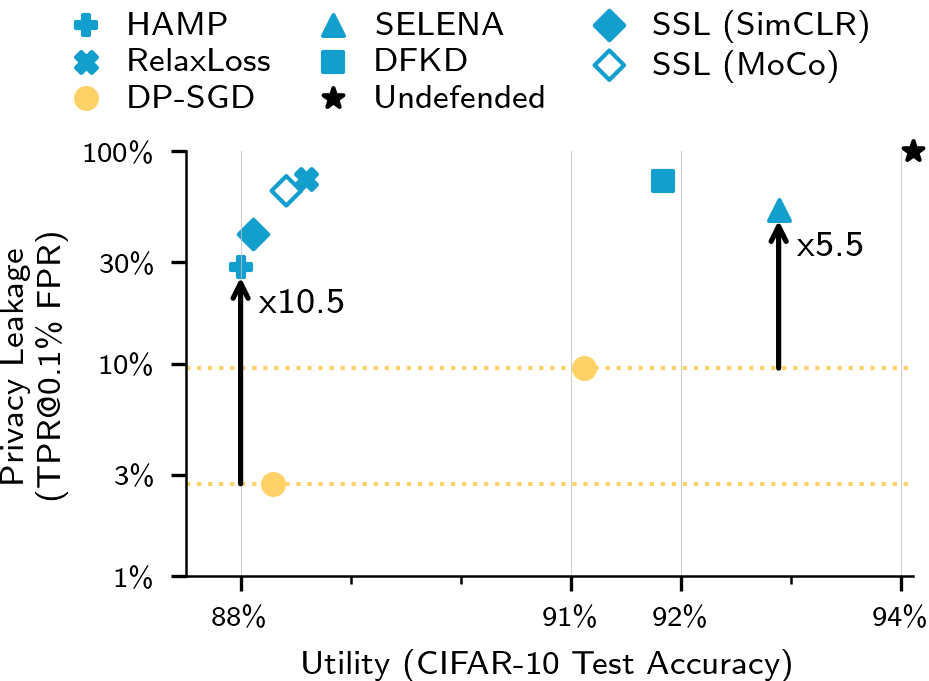

In [30]:
fig, ax = plt.subplots()

DEFENSE_STYLE_MAP = {
    "dpsgd_medium": ("C1", "o", True),
    "dpsgd_high": ("C1", "o", True),
    "undefended": ("k", "*", True),
    "hamp": ("C0", "P", True),
    "relax_loss": ("C0", "X", True),
    "selena": ("C0", "^", True),
    "dfkd": ("C0", "s", True),
    "ssl_simclr": ("C0", "D", True),
    "ssl_moco": ("C0", "D", False),
}

# DP-SGD TPR baseline
ax.axhline(comparison_data["dpsgd_high"]["ours"][1], ls="dotted", c=DEFENSE_STYLE_MAP["dpsgd_high"][0], lw=1)
ax.axhline(comparison_data["dpsgd_medium"]["ours"][1], ls="dotted", c=DEFENSE_STYLE_MAP["dpsgd_medium"][0], lw=1)

for defense_idx, (defense, (color, marker, filled)) in enumerate(DEFENSE_STYLE_MAP.items()):
    (ours_accuracy, ours_tpr_at_fpr) = comparison_data[defense]["ours"]
    defense_name = comparison_data[defense]["name"]
    if filled:
        facecolor = color
    else:
        facecolor = "none"

    ax.scatter(
        ours_accuracy, ours_tpr_at_fpr,
        marker=marker,
        label=defense_name,
        facecolor=facecolor,
        edgecolor=color,
        clip_on=False,
        linewidth=1.0,  # FIXME: Default line width is too big
    )

# Add arrows with X increase
COMPARISONS = (
    ("dpsgd_medium", "hamp"),
    ("dpsgd_high", "selena"),
)
for comparison_source, comparison_target in COMPARISONS:
    src_utility, src_tpr = comparison_data[comparison_source]["ours"]
    tgt_utility, tgt_tpr = comparison_data[comparison_target]["ours"]
    relative_increase = tgt_tpr / src_tpr
    print(comparison_target, tgt_tpr, src_tpr, relative_increase)
    
    ax.annotate(
        "",
        xytext=(tgt_utility, src_tpr),
        xy=(tgt_utility, tgt_tpr),
        arrowprops=dict(arrowstyle="->", color="k", ls="solid", shrinkB=matplotlib.rcParams["lines.markersize"] / 2, shrinkA=0),
    )
    ax.annotate(
        f"x{relative_increase:.1f}",
        xy=(tgt_utility, tgt_tpr),
        xytext=(0.5, -0.5),
        textcoords="offset fontsize",
        verticalalignment="top",
    )

ax.set_xlabel("Utility (CIFAR-10 Test Accuracy)")
ax.set_yscale("log")
ax.minorticks_off()
ax.set_ylim(1e-2, 1)
ax.set_yticks((0.01, 0.03, 0.1, 0.3, 1.0))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel("Privacy Leakage\n(TPR@0.1\\% FPR)")

ax.set_xlim(0.875, comparison_data["undefended"]["ours"][0])
ax.set_xticks((0.88, 0.91, 0.92, 0.94))
ax.set_xticks(np.linspace(0.88, 0.94, 7), minor=True)
ax.grid(visible=True, which="major", axis="x")

legend_handles, legend_labels = ax.get_legend_handles_labels()
# Drop one of the two DP-SGDs
legend_handles = legend_handles[1:]
legend_labels = legend_labels[1:]
legend_labels[0] = "DP-SGD"

legend_handles = legend_handles[2:4] + [legend_handles[0]] + legend_handles[4:6] + [legend_handles[1]] + legend_handles[6:]
legend_labels = legend_labels[2:4] + [legend_labels[0]] + legend_labels[4:6] + [legend_labels[1]] + legend_labels[6:]

fig.legend(legend_handles, legend_labels, loc="outside upper center", ncol=3)
plot_util.resize_figure_with_legend(fig)

fig.savefig(PLOT_BASE_DIR / "dpsgd_comparison.pdf")

plt.show(fig)
plt.close(fig)

# Auxiliary things

## Accuracy and TPR table

In [31]:
# Collect data
comparison_data = {}

## SELENA
print("# Loading SELENA data")
SELENA_BASE = "clean", "lira_da", "logit"
SELENA_OURS = "duplicates_mislabel_half", "lira_da", "logit"
client = mlflow.client.MlflowClient(f"file://{SELENA_BASE_DIR}/mlruns")
current_data = {}
for setting, (experiment_name, attack, score) in {"base": SELENA_BASE, "ours": SELENA_OURS}.items():
    print(f"## Loading {experiment_name} data")
    experiment = client.get_experiment_by_name(experiment_name)
    accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
    all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
    for shadow_model_idx in range(NUM_SHADOW):
        run, = filter(
            lambda run: 
                run.info.run_name.startswith("student") 
                and run.info.status == "FINISHED"
                and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
            all_runs
        )
        assert run.info.status == "FINISHED"
        accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
    attack_scores = torch.load(
        SELENA_BASE_DIR / experiment_name / f"attack_scores_student_{attack}_{score}.pt"
    ).numpy()
    attack_membership = torch.load(
        SELENA_BASE_DIR / experiment_name / f"attack_membership_student_{attack}_{score}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_score=attack_scores, y_true=attack_membership,
    )
    tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
    current_data[setting] = ((np.mean(accuracies), np.std(accuracies) / np.sqrt(len(accuracies))), tpr_at_fpr)
current_data["name"] = f"SELENA"
comparison_data["selena"] = current_data

## SSL
print("# Loading SSL data")
SSL_BASE = "clean", "lira_da", "confidence"
SSL_OURS = "ood", "lira_da", "backbone"
for ssl_method, method_name, base_dir in (("simclr", "SimCLR", SSL_SIMCLR_BASE_DIR), ("moco", "MoCo", SSL_MOCO_BASE_DIR)):
    print(f"## Loading {ssl_method} data")
    current_data = {}
    client = mlflow.client.MlflowClient(f"file://{base_dir}/mlruns")
    for setting, (experiment_name, attack, threat_model) in {"base": SSL_BASE, "ours": SSL_OURS}.items():
        print(f"### Loading {setting} data")
        experiment = client.get_experiment_by_name(experiment_name)
        accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
        all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
        for shadow_model_idx in range(NUM_SHADOW):
            run, *_ = tuple(sorted(
                filter(
                    lambda run: 
                        run.info.status == "FINISHED"
                        and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
                    all_runs
                ),
                key=lambda run: run.info.end_time,
                reverse=True,
            ))
            assert run.info.status == "FINISHED"
            accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
        attack_scores = torch.load(
            base_dir / experiment_name / f"attack_scores_{attack}_{threat_model}.pt"
        ).numpy()
        attack_membership = torch.load(
            base_dir / experiment_name / f"attack_membership_{attack}_{threat_model}.pt"
        ).numpy()
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            y_score=attack_scores, y_true=attack_membership,
        )
        tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
        current_data[setting] = ((np.mean(accuracies), np.std(accuracies) / np.sqrt(len(accuracies))), tpr_at_fpr)
    current_data["name"] = f"SSL ({method_name})"
    comparison_data[f"ssl_{ssl_method}"] = current_data

## DFKD
print("# Loading DFKD data")
DFKD_BASE = "clean", "lira_da", "logit"
DFKD_OURS = "label_noise", "lira_da", "logit"
client = mlflow.client.MlflowClient(f"file://{DFKD_BASE_DIR}/mlruns")
current_data = {}
for setting, (experiment_name, attack, score) in {"base": DFKD_BASE, "ours": DFKD_OURS}.items():
    print(f"## Loading {experiment_name} data")
    experiment = client.get_experiment_by_name(experiment_name)
    accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
    all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
    for shadow_model_idx in range(NUM_SHADOW):
        run, = filter(
            lambda run: 
                run.info.status == "FINISHED"
                and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
            all_runs
        )
        assert run.info.status == "FINISHED"
        accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
    attack_scores = torch.load(
        DFKD_BASE_DIR / experiment_name / f"attack_scores_{attack}_{score}.pt"
    ).numpy()
    attack_membership = torch.load(
        DFKD_BASE_DIR / experiment_name / f"attack_membership_{attack}_{score}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_score=attack_scores, y_true=attack_membership,
    )
    tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
    current_data[setting] = ((np.mean(accuracies), np.std(accuracies) / np.sqrt(len(accuracies))), tpr_at_fpr)
current_data["name"] = f"DFKD"
comparison_data["dfkd"] = current_data

## HAMP
print("# Loading HAMP data")
HAMP_BASE_CANARY_TYPE, HAMP_BASE_ATTACK, HAMP_BASE_SCORE = "clean", "lira_da", "logit"
HAMP_OURS_CANARY_TYPE = "label_noise"
HAMP_HP_IDX = 4
client = mlflow.client.MlflowClient(f"file://{HAMP_BASE_DIR}/mlruns")
experiment_hamp_base = client.get_experiment_by_name(HAMP_BASE_CANARY_TYPE)
experiment_hamp_ours = client.get_experiment_by_name(HAMP_OURS_CANARY_TYPE)
all_runs_base = tuple(client.search_runs(experiment_hamp_base.experiment_id, max_results=50000))
all_runs_ours = tuple(client.search_runs(experiment_hamp_ours.experiment_id, max_results=50000))
hamp_accuracies_base = np.empty(NUM_SHADOW, dtype=np.float64)
hamp_accuracies_ours = np.empty(NUM_SHADOW, dtype=np.float64)
for shadow_model_idx in range(NUM_SHADOW):
    run_base, = filter(
        lambda run: 
            run.info.run_name.endswith(f"train_{HAMP_HP_IDX}")
            and run.info.status == "FINISHED"
            and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
        all_runs_base
    )
    assert run_base.info.status == "FINISHED"
    run_ours, = filter(
        lambda run: 
            run.info.run_name.endswith(f"train_{HAMP_HP_IDX}")
            and run.info.status == "FINISHED"
            and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
        all_runs_ours
    )
    assert run_ours.info.status == "FINISHED"
    hamp_accuracies_base[shadow_model_idx] = run_base.data.metrics["test_accuracy"]
    hamp_accuracies_ours[shadow_model_idx] = run_ours.data.metrics["test_accuracy"]
hamp_base_attack_scores = torch.load(
    HAMP_BASE_DIR / HAMP_BASE_CANARY_TYPE / f"attack_train_{HAMP_HP_IDX}" / f"attack_scores_testtime_{HAMP_BASE_ATTACK}_{HAMP_BASE_SCORE}.pt"
).numpy()
hamp_base_attack_membership = torch.load(
    HAMP_BASE_DIR / HAMP_BASE_CANARY_TYPE / f"attack_train_{HAMP_HP_IDX}" / f"attack_membership_testtime_{HAMP_BASE_ATTACK}_{HAMP_BASE_SCORE}.pt"
).numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(
    y_score=hamp_base_attack_scores, y_true=hamp_base_attack_membership,
)
hamp_base_tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
hamp_ours_attack_scores = torch.load(
    HAMP_BASE_DIR / HAMP_OURS_CANARY_TYPE / f"attack_train_{HAMP_HP_IDX}" / f"attack_scores_labelonly_default.pt"
).numpy()
hamp_ours_attack_membership = torch.load(
    HAMP_BASE_DIR / HAMP_OURS_CANARY_TYPE / f"attack_train_{HAMP_HP_IDX}" / f"attack_membership_labelonly_default.pt"
).numpy()
fpr, tpr, _ = sklearn.metrics.roc_curve(
    y_score=hamp_ours_attack_scores, y_true=hamp_ours_attack_membership,
)
hamp_ours_tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
comparison_data["hamp"] = {
    "base": ((np.mean(hamp_accuracies_base), np.std(hamp_accuracies_base) / np.sqrt(len(hamp_accuracies_base))), hamp_base_tpr_at_fpr),
    "ours": ((np.mean(hamp_accuracies_ours), np.std(hamp_accuracies_ours) / np.sqrt(len(hamp_accuracies_ours))), hamp_ours_tpr_at_fpr),
    "name": "HAMP",
}

## RelaxLoss
print("# Loading RelaxLoss data")
RELAX_LOSS_BASE = "clean", "lira", "logit", 0
RELAX_LOSS_OURS = "label_noise", "lira", "hinge", 0
RELAX_LOSS_HP_IDX = 0
client = mlflow.client.MlflowClient(f"file://{RELAX_LOSS_BASE_DIR}/mlruns")
current_data = {}
for setting, (canary_type, attack, score, num_poison) in {"base": RELAX_LOSS_BASE, "ours": RELAX_LOSS_OURS}.items():
    experiment_name = f"{canary_type}_{num_poison}"
    print(f"## Loading {experiment_name} data")
    experiment = client.get_experiment_by_name(experiment_name)
    all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
    accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
    for shadow_model_idx in range(NUM_SHADOW):
        run, = filter(
            lambda run: 
                run.info.run_name.endswith(f"target_loss_{RELAX_LOSS_HP_IDX}") 
                and run.info.status == "FINISHED"
                and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
            all_runs
        )
        assert run.info.status == "FINISHED"
        accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
    attack_scores = torch.load(
        RELAX_LOSS_BASE_DIR / experiment_name / f"attack_target_loss_{RELAX_LOSS_HP_IDX}" / f"attack_scores_{attack}_{score}.pt"
    ).numpy()
    attack_membership = torch.load(
        RELAX_LOSS_BASE_DIR / experiment_name / f"attack_target_loss_{RELAX_LOSS_HP_IDX}" / f"attack_membership_{attack}_{score}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_score=attack_scores, y_true=attack_membership,
    )
    tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
    current_data[setting] = ((np.mean(accuracies), np.std(accuracies) / np.sqrt(len(accuracies))), tpr_at_fpr)
current_data["name"] = f"RelaxLoss"
comparison_data[f"relax_loss"] = current_data

## DP-SGD
print("# Loading DP-SGD data")
DPSGD_BASE = "clean", "lira_da", "hinge"
DPSGD_MEDIUM_OURS = "label_noise", "lira", "logit"
DPSGD_HIGH_OURS = "ood", "lira_da", "hinge"
DPSGD_VERYHIGH_OURS = "label_noise", "lira_da", "logit"
client = mlflow.client.MlflowClient(f"file://{DPSGD_BASE_DIR}/mlruns")
DPSGD_BASELINE_MAP = {
    "medium": DPSGD_MEDIUM_OURS,
    "high": DPSGD_HIGH_OURS,
    "veryhigh": DPSGD_VERYHIGH_OURS,
}
for baseline, current_ours in DPSGD_BASELINE_MAP.items():
    print(f"## Loading {baseline} baseline")
    current_data = {}
    for setting, (canary_type, attack, score) in {"base": DPSGD_BASE, "ours": current_ours}.items():
        experiment_name = f"{baseline}_{canary_type}"
        print(f"### Loading {experiment_name} data")
        experiment = client.get_experiment_by_name(experiment_name)
        accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
        all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
        for shadow_model_idx in range(NUM_SHADOW):
            run, = filter(
                lambda run: 
                    run.info.status == "FINISHED"
                    and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
                all_runs
            )
            assert run.info.status == "FINISHED"
            accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
        attack_scores = torch.load(
            DPSGD_BASE_DIR / experiment_name / f"attack_scores_{attack}_{score}.pt"
        ).numpy()
        attack_membership = torch.load(
            DPSGD_BASE_DIR / experiment_name / f"attack_membership_{attack}_{score}.pt"
        ).numpy()
        fpr, tpr, _ = sklearn.metrics.roc_curve(
            y_score=attack_scores, y_true=attack_membership,
        )
        tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
        current_data[setting] = ((np.mean(accuracies), np.std(accuracies) / np.sqrt(len(accuracies))), tpr_at_fpr)
    current_data["name"] = f"DP-SGD ({baseline} utility)"
    comparison_data[f"dpsgd_{baseline}"] = current_data

## Undefended
print("# Loading undefended data")
UNDEFENDED_BASE = "clean", "lira_da", "hinge"
UNDEFENDED_OURS = "label_noise", "lira_da", "hinge"
client = mlflow.client.MlflowClient(f"file://{UNDEFENDED_BASE_DIR}/mlruns")
current_data = {}
for setting, (experiment_name, attack, score) in {"base": UNDEFENDED_BASE, "ours": UNDEFENDED_OURS}.items():
    print(f"## Loading {experiment_name} data")
    experiment = client.get_experiment_by_name(experiment_name)
    accuracies = np.empty(NUM_SHADOW, dtype=np.float64)
    all_runs = tuple(client.search_runs(experiment.experiment_id, max_results=50000))
    for shadow_model_idx in range(NUM_SHADOW):
        run, = filter(
            lambda run: 
                run.info.status == "FINISHED"
                and run.data.params["shadow_model_idx"] == str(shadow_model_idx),
            all_runs
        )
        assert run.info.status == "FINISHED"
        accuracies[shadow_model_idx] = run.data.metrics["test_accuracy"]
    attack_scores = torch.load(
        UNDEFENDED_BASE_DIR / experiment_name / f"attack_scores_{attack}_{score}.pt"
    ).numpy()
    attack_membership = torch.load(
        UNDEFENDED_BASE_DIR / experiment_name / f"attack_membership_{attack}_{score}.pt"
    ).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(
        y_score=attack_scores, y_true=attack_membership,
    )
    tpr_at_fpr = max(tpr[fpr <= TARGET_FPR])
    current_data[setting] = ((np.mean(accuracies), np.std(accuracies) / np.sqrt(len(accuracies))), tpr_at_fpr)
current_data["name"] = f"Undefended"
comparison_data["undefended"] = current_data


# Loading SELENA data
## Loading clean data
## Loading duplicates_mislabel_half data
# Loading SSL data
## Loading simclr data
### Loading base data
### Loading ours data
## Loading moco data
### Loading base data
### Loading ours data
# Loading DFKD data
## Loading clean data
## Loading label_noise data
# Loading HAMP data
# Loading RelaxLoss data
## Loading clean_0 data
## Loading label_noise_0 data
# Loading DP-SGD data
## Loading medium baseline
### Loading medium_clean data
### Loading medium_label_noise data
## Loading high baseline
### Loading high_clean data
### Loading high_ood data
## Loading veryhigh baseline
### Loading veryhigh_clean data
### Loading veryhigh_label_noise data
# Loading undefended data
## Loading clean data
## Loading label_noise data


In [32]:
DEFENSE_ORDER = (
    "hamp",
    "relax_loss",
    "selena",
    "ssl_simclr",
    "ssl_moco",
    "dfkd",
    "dpsgd_medium",
    "dpsgd_high",
    "dpsgd_veryhigh",
    "undefended",
)

for defense in DEFENSE_ORDER:
    data = comparison_data[defense]
    accs_base = data['base'][0]
    accs_ours = data['ours'][0]
    print(fr"{data['name']} & "
          fr"{data['base'][1]*100:.1f}\% & "
          fr"{data['ours'][1]*100:.1f}\% & "
          fr"& "
          fr"{accs_base[0]*100:.2f}\% ($\pm {accs_base[1]*100:.2f}$) & "
          fr"{accs_ours[0]*100:.2f}\% ($\pm {accs_ours[1]*100:.2f}$) \\"
    )


HAMP & 2.1\% & 28.5\% & & 88.29\% ($\pm 0.04$) & 88.00\% ($\pm 0.04$) \\
RelaxLoss & 2.2\% & 74.1\% & & 88.86\% ($\pm 0.03$) & 88.60\% ($\pm 0.03$) \\
SELENA & 6.8\% & 52.7\% & & 93.05\% ($\pm 0.02$) & 92.88\% ($\pm 0.02$) \\
SSL (SimCLR) & 5.8\% & 40.6\% & & 88.18\% ($\pm 0.02$) & 88.11\% ($\pm 0.03$) \\
SSL (MoCo) & 2.0\% & 65.0\% & & 88.44\% ($\pm 0.04$) & 88.41\% ($\pm 0.04$) \\
DFKD & 1.3\% & 72.2\% & & 92.39\% ($\pm 0.03$) & 91.84\% ($\pm 0.03$) \\
DP-SGD (medium utility) & 0.7\% & 2.7\% & & 88.29\% ($\pm 0.03$) & 88.29\% ($\pm 0.03$) \\
DP-SGD (high utility) & 2.2\% & 9.5\% & & 91.13\% ($\pm 0.03$) & 91.12\% ($\pm 0.02$) \\
DP-SGD (veryhigh utility) & 4.8\% & 63.2\% & & 91.89\% ($\pm 0.03$) & 91.79\% ($\pm 0.03$) \\
Undefended & 13.4\% & 100.0\% & & 94.52\% ($\pm 0.02$) & 94.10\% ($\pm 0.02$) \\
